### Importing the required libraries and files

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.utils import shuffle
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs


from google.colab import files
from statistics import mode, mean
from matplotlib.pyplot import figure

import scipy.cluster.hierarchy as sch
from scipy import stats as s

import random
import pandas as pd 
import numpy as np
import statistics
import matplotlib.pyplot as plt

In [ ]:
!gdown --id 1MxvEHNGvFgc9z2mbH8_HHzi7z7ISMpfL #tvsum50.xlsx
!gdown --id 1hWy9xeGKWFcg_PiWo7fhrTsh_e0N452i #eccv16_dataset_tvsum_google_pool5.h5
!gdown --id 1PZyFjsAWcSiD7EVQbUoaG7MEBw5a-eWw #TV50_352353_20.csv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1MxvEHNGvFgc9z2mbH8_HHzi7z7ISMpfL
To: /content/tvsum50.xlsx
100% 24.8M/24.8M [00:00<00:00, 81.2MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1hWy9xeGKWFcg_PiWo7fhrTsh_e0N452i
To: /content/eccv16_dataset_tvsum_google_pool5.h5
100% 125M/125M [00:01<00:00, 98.4MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,


In [ ]:
import h5py
tvsum_h5 = h5py.File('eccv16_dataset_tvsum_google_pool5.h5', 'r')
change_points = []
gt_score = []
for i in range(1,51):
  change_points.append(list(tvsum_h5["video_"+str(i)]['change_points'][:])) #getting the change points from the h5 file
  gt_score.append(list(tvsum_h5["video_"+str(i)]['gtscore'][:])) #GT scores from the h5 file

In [ ]:
len(change_points[0])

71

In [ ]:
df=pd.read_csv('TV50_352353_20.csv', header=None)

## Segment analysis

### K means for a sample video

In [ ]:
#getting GT score and change points for video 1
a = gt_score[:][0]
b = change_points[:][0]
final_gt_score = [ item for elem in b for item in elem]

In [ ]:
#video 1 annotations
df1=pd.read_excel(open('tvsum50.xlsx', 'rb'),sheet_name=1, header=None)
df = df1.iloc[:,0:20]

In [ ]:
#creating a list with all segments
segments = []
for i in range(0,len(final_gt_score),2):
  segments.append([final_gt_score[i],final_gt_score[i+1]])

In [ ]:
#create a dataframe with average score of each annotator in a segment
segment_df = pd.DataFrame()
for j in range(20):
  segment_mean = []
  for i in segments:
    a = df[j][i[0]:i[1]]
    avg = a.mean(axis=0)
    segment_mean.append(avg)
  segment_df[j] = segment_mean

In [ ]:
#running K means
group_1 = []  # the group 1 of clusters
group_2 = []  # the group 2 of clusters
for i in range(5):
   kmeans = KMeans(n_clusters=2, algorithm = 'auto', copy_x=False)
   kmeans.fit(segment_df.T)
   group_1.append(segment_df.T[kmeans.labels_==0])
   group_2.append(segment_df.T[kmeans.labels_==1])
a = [list(group_1[k].index) for k in range(5)]
b = [list(group_2[k].index) for k in range(5)]
print("Group 1")
for xs in range(len(a)):
  print("Result for run",xs+1,"is: "," ".join(map(str, a[xs])))
print("\nGroup 2")
for xs in range(len(b)):
  print("Result for run",xs+1,"is: "," ".join(map(str, b[xs])))
print()

Group 1
Result for run 1 is:  2 5 6 8 9 12 14 15 16 17 19
Result for run 2 is:  0 1 3 4 7 10 11 12 13 18
Result for run 3 is:  0 3 6 7 9 12 17 18 19
Result for run 4 is:  2 5 6 8 9 12 14 15 16 17 19
Result for run 5 is:  2 5 6 8 9 14 15 16 17 19

Group 2
Result for run 1 is:  0 1 3 4 7 10 11 13 18
Result for run 2 is:  2 5 6 8 9 14 15 16 17 19
Result for run 3 is:  1 2 4 5 8 10 11 13 14 15 16
Result for run 4 is:  0 1 3 4 7 10 11 13 18
Result for run 5 is:  0 1 3 4 7 10 11 12 13 18



In [ ]:
total = []
for i in range(len(change_points)):
  for j in range(len(change_points[:][i])):
    total.append(change_points[:][i][j])
    #print("change point:",change_points[:][i][j] )

### K means for all videos individually

In [ ]:
# running K means for every video individually
for z in range(1,51):
  #opening the corresponding annotation workbook
  df1=pd.read_excel(open('tvsum50.xlsx', 'rb'),sheet_name=z, header=None)
  df = df1.iloc[:,0:20]
  #getting the changepoints
  b = change_points[:][z-1]
  final_change_points = [ item for elem in b for item in elem]
  segments = []
  for i in range(0,len(final_change_points),2):
    segments.append([final_change_points[i],final_change_points[i+1]])
  #creating a dataframe with segment average
  segment_df = pd.DataFrame()
  for j in range(20):
    segment_mean = []
    for i in segments:
      a = df[j][i[0]:i[1]]
      avg = a.mean(axis=0)
      segment_mean.append(avg)
    segment_df[j] = segment_mean
  #runnning K means
  group_1 = []  # the group 1 of clusters
  group_2 = []  # the group 2 of clusters
  for i in range(5):
    kmeans = KMeans(n_clusters=2, algorithm = 'auto', copy_x=False)
    kmeans.fit(segment_df.T)
    group_1.append(segment_df.T[kmeans.labels_==0])
    group_2.append(segment_df.T[kmeans.labels_==1])
  a = [list(group_1[k].index) for k in range(5)]
  b = [list(group_2[k].index) for k in range(5)]
  print("Results for video",z)
  print("Group 1")
  for xs in range(len(a)):
    print("Result for run",xs+1,"is: "," ".join(map(str, a[xs])))
  print("\nGroup 2")
  for xs in range(len(b)):
    print("Result for run",xs+1,"is: "," ".join(map(str, b[xs])))
  print()
#consistent results for video 3,4,14,15,17,21,22,31,34,38,39,40,41,44,46,47

Results for video 1
Group 1
Result for run 1 is:  0 1 3 4 7 10 11 12 13 18
Result for run 2 is:  2 5 6 8 9 14 15 16 17 19
Result for run 3 is:  0 3 7 17 19
Result for run 4 is:  2 5 6 8 9 14 15 16 17 19
Result for run 5 is:  1 3 4 10 11 13 18

Group 2
Result for run 1 is:  2 5 6 8 9 14 15 16 17 19
Result for run 2 is:  0 1 3 4 7 10 11 12 13 18
Result for run 3 is:  1 2 4 5 6 8 9 10 11 12 13 14 15 16 18
Result for run 4 is:  0 1 3 4 7 10 11 12 13 18
Result for run 5 is:  0 2 5 6 7 8 9 12 14 15 16 17 19

Results for video 2
Group 1
Result for run 1 is:  0 1 2 4 6 7 8 10 12 13 16 17 18
Result for run 2 is:  3 5 9 11 14 15 19
Result for run 3 is:  3 9 11 14 15 19
Result for run 4 is:  3 5 9 11 13 14 15 19
Result for run 5 is:  0 1 2 4 5 6 7 8 10 12 13 16 17 18

Group 2
Result for run 1 is:  3 5 9 11 14 15 19
Result for run 2 is:  0 1 2 4 6 7 8 10 12 13 16 17 18
Result for run 3 is:  0 1 2 4 5 6 7 8 10 12 13 16 17 18
Result for run 4 is:  0 1 2 4 6 7 8 10 12 16 17 18
Result for run 5 is:  3

### K means for all segments

In [ ]:
#compliling segment scores for all videos
master_df = pd.DataFrame()
for z in range(1,51):
  #opening the corresponding annotation workbook
  df1=pd.read_excel(open('tvsum50.xlsx', 'rb'),sheet_name=z, header=None)
  df = df1.iloc[:,0:20]
  #getting the changepoints
  b = change_points[:][z-1]
  final_change_points = [ item for elem in b for item in elem]
  segments = []
  for i in range(0,len(final_change_points),2):
    segments.append([final_change_points[i],final_change_points[i+1]])
  #creating a dataframe with segment average
  segment_df = pd.DataFrame()
  for j in range(20):
    segment_mean = []
    for i in segments:
      a = df[j][i[0]:i[1]]
      avg = a.mean(axis=0)
      segment_mean.append(avg)
    segment_df[j] = segment_mean
  master_df = master_df.append(segment_df, ignore_index=True)

In [ ]:
x = master_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
master_scaled_df = pd.DataFrame(x_scaled)

In [ ]:
#calculating the silhouette coefficiend at SSE for K from 2-10, 5 times to look for patterns
SSE = [] 
SLC = []
for i in range(5):
  sse = []
  slc=[]
  for k in range(1,10):
    kmeans = KMeans(n_clusters=k, init= "random", max_iter=100000)
    kmeans.fit(master_df.T)
    sse.append(kmeans.inertia_)
    if k!=1:
      XXX, YYY = shuffle(master_df.T, kmeans.labels_)
      slc.append(silhouette_score(XXX, YYY))
  SSE.append(sse)
  SLC.append(slc)

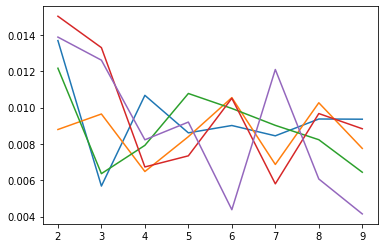

In [ ]:
for j in range(5):
  plt.plot([i for i in range(2,10)],SLC[j]) #no apparent pattern

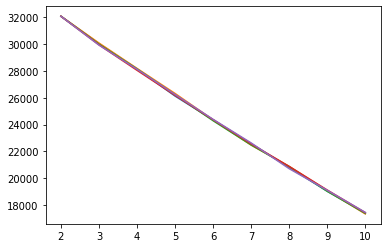

In [ ]:
for j in range(5): #plotting the SSE
  plt.plot([i for i in range(2,11)],SSE[j]) 

In [ ]:
#runnning K means on raw data
group_1 = []  # the group 1 of clusters
group_2 = []  # the group 2 of clusters
for i in range(5):
  kmeans = KMeans(n_clusters=2, algorithm = 'auto')
  kmeans.fit(master_df.T)
  group_1.append(master_df.T[kmeans.labels_==0])
  group_2.append(master_df.T[kmeans.labels_==1])
a = [list(group_1[k].index) for k in range(5)]
b = [list(group_2[k].index) for k in range(5)]
print("Group 1")
for xs in range(len(a)):
  print("Result for run",xs+1,"is: "," ".join(map(str, a[xs])))
print("\nGroup 2")
for xs in range(len(b)):
  print("Result for run",xs+1,"is: "," ".join(map(str, b[xs])))
print()

Group 1
Result for run 1 is:  0 1 2 4 7 8 10 11 14 15 16 17 18 19
Result for run 2 is:  0 4 8 11 14 16 17 18 19
Result for run 3 is:  1 2 3 5 6 7 9 11 12 13 15
Result for run 4 is:  3 5 6 7 9 10 11 13 15
Result for run 5 is:  3 5 7 9 11 12 13 15

Group 2
Result for run 1 is:  3 5 6 9 12 13
Result for run 2 is:  1 2 3 5 6 7 9 10 12 13 15
Result for run 3 is:  0 4 8 10 14 16 17 18 19
Result for run 4 is:  0 1 2 4 8 12 14 16 17 18 19
Result for run 5 is:  0 1 2 4 6 8 10 14 16 17 18 19



In [ ]:
#runnning K means on scaled data
group_1 = []  # the group 1 of clusters
group_2 = []  # the group 2 of clusters
for i in range(5):
  kmeans = KMeans(n_clusters=2, algorithm = 'auto', copy_x=False)
  kmeans.fit(master_scaled_df.T)
  group_1.append(master_scaled_df.T[kmeans.labels_==0])
  group_2.append(master_scaled_df.T[kmeans.labels_==1])
a = [list(group_1[k].index) for k in range(5)]
b = [list(group_2[k].index) for k in range(5)]
print("Group 1")
for xs in range(len(a)):
  print("Result for run",xs+1,"is: "," ".join(map(str, a[xs])))
print("\nGroup 2")
for xs in range(len(b)):
  print("Result for run",xs+1,"is: "," ".join(map(str, b[xs])))
print()

Group 1
Result for run 1 is:  1 2 3 5 6 7 9 10 12 13 15
Result for run 2 is:  3 5 6 9 12 13
Result for run 3 is:  3 5 6 7 9 10 11 12 13 15 17 18
Result for run 4 is:  3 5 6 9 12 13
Result for run 5 is:  3 5 6 7 9 10 11 12 13 15 17 18

Group 2
Result for run 1 is:  0 4 8 11 14 16 17 18 19
Result for run 2 is:  0 1 2 4 7 8 10 11 14 15 16 17 18 19
Result for run 3 is:  0 1 2 4 8 14 16 19
Result for run 4 is:  0 1 2 4 7 8 10 11 14 15 16 17 18 19
Result for run 5 is:  0 1 2 4 8 14 16 19



### K means for all categories

In [ ]:
for z in range(1,51,5):
  #compliling the data for videos in 1 category
  df1=pd.read_excel(open('segment_scores.xlsx', 'rb'),sheet_name=z+0, header=None)
  df2=pd.read_excel(open('segment_scores.xlsx', 'rb'),sheet_name=z+1, header=None)
  df3=pd.read_excel(open('segment_scores.xlsx', 'rb'),sheet_name=z+2, header=None)
  df4=pd.read_excel(open('segment_scores.xlsx', 'rb'),sheet_name=z+3, header=None)
  df5=pd.read_excel(open('segment_scores.xlsx', 'rb'),sheet_name=z+4, header=None)
  df_category = pd.concat([df1,df2,df3,df4,df5])
  df_category.loc[:, 20]=list(df_category.mean(axis=1))
  df_category = df_category.drop(df_category.index[0])
  df_category = df_category.drop(df_category.index[0],axis = 1) 
 
  #normalizing the data
  x = df_category.values #returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  category_scaled_df = pd.DataFrame(x_scaled)

  #runnning K means on raw data
  group_1 = []  # the group 1 of clusters
  group_2 = []  # the group 2 of clusters
  for i in range(5):
    kmeans = KMeans(n_clusters=2, algorithm = 'auto')
    kmeans.fit(category_scaled_df.T)
    group_1.append(category_scaled_df.T[kmeans.labels_==0])
    group_2.append(category_scaled_df.T[kmeans.labels_==1])
  a = [list(group_1[k].index) for k in range(5)]
  b = [list(group_2[k].index) for k in range(5)]
  print("Results for category",z//5+1)
  print("Group 1")
  for xs in range(len(a)):
    print("Result for run",xs+1,"is: "," ".join(map(str, a[xs])))
  print("\nGroup 2")
  for xs in range(len(b)):
    print("Result for run",xs+1,"is: "," ".join(map(str, b[xs])))
  print()

Results for category 1
Group 1
Result for run 1 is:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
Result for run 2 is:  0 19
Result for run 3 is:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
Result for run 4 is:  0 19
Result for run 5 is:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18

Group 2
Result for run 1 is:  0 19
Result for run 2 is:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
Result for run 3 is:  0 19
Result for run 4 is:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
Result for run 5 is:  0 19

Results for category 2
Group 1
Result for run 1 is:  0 19
Result for run 2 is:  0 19
Result for run 3 is:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
Result for run 4 is:  0 19
Result for run 5 is:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18

Group 2
Result for run 1 is:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
Result for run 2 is:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
Result for run 3 is:  0 19
Result for run 4 is:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
Result

## Visualizing the data

In [ ]:
#not sure what this section does. will have to run and find out

video_number = 1
total = []
for i in range(len(change_points)):
  for j in range(len(change_points[:][i])):
    total.append(change_points[:][i][j])
    #print("change point:",change_points[:][i][j] )
#getting GT score and change points for video 1
a = gt_score[:][video_number-1]
b = change_points[:][video_number-1]
final_gt_score = [ item for elem in b for item in elem]
#video 1 annotations
df1=pd.read_excel(open('tvsum50.xlsx', 'rb'),sheet_name=video_number, header=None)
df = df1.iloc[:,0:20]
#creating a list with all segments
segments = []
for i in range(0,len(final_gt_score),2):
  segments.append([final_gt_score[i],final_gt_score[i+1]])
#create a dataframe with average score of each annotator in a segment
segment_df = pd.DataFrame()
for j in range(20):
  segment_mean = []
  for i in segments:
    a = df[j][i[0]:i[1]]
    avg = a.mean(axis=0)
    segment_mean.append(avg)
  segment_df[j] = segment_mean

NameError: ignored

In [ ]:
average = segment_df.mean(axis=1)
bins_list = []
for i in segments:
  bins_list.append(i[0])

## Creating excel file with segment scores

In [ ]:
# To create a new excel file with all the segment scores
for z in range(1,51):
  #opening the corresponding annotation workbook
  df1=pd.read_excel(open('tvsum50.xlsx', 'rb'),sheet_name=z, header=None)
  df = df1.iloc[:,0:20] #getting the change points
  b = change_points[:][z-1]
  final_change_points = [ item for elem in b for item in elem]
  segments = []
  for i in range(0,len(final_change_points),2):
    segments.append([final_change_points[i],final_change_points[i+1]]) 
  segment_df = pd.DataFrame() #creating a dataframe with segment average
  for j in range(20):
    segment_mean = []
    for i in segments:
      a = df[j][i[0]:i[1]]
      avg = a.mean(axis=0)
      segment_mean.append(avg)
    segment_df[j] = segment_mean
  with pd.ExcelWriter('segment_scores.xlsx',mode = 'a') as writer: #writing the scores for individual scores
    segment_df.to_excel(writer, sheet_name=str(z))
with pd.ExcelWriter('segment_scores.xlsx',mode = 'a') as writer: #writing the scores with all the data
  master_df.to_excel(writer, sheet_name='all')

## CronbachAlpha 

In [ ]:
def CronbachAlpha(itemscores):
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=1, ddof=1)
    tscores = itemscores.sum(axis=0)
    nitems = len(itemscores)

    return nitems / (nitems-1.) * (1 - itemvars.sum() / tscores.var(ddof=1))

In [ ]:
import pandas as pd
import numpy as np

# sample data
data = {'A1': [4,1,1,1,4], 'A2': [2,1,1,2,1],
        'A3':[3,1,1,1,2], 'A20': [3,2,1,1,4]}  
df = pd.DataFrame(data)
print(df)
print()
print('The cronbach alpha is:',CronbachAlpha(df.T))

   A1  A2  A3  A20
0   4   2   3    3
1   1   1   1    2
2   1   1   1    1
3   1   2   1    1
4   4   1   2    4

The cronbach alpha is: 0.8205128205128205


In [ ]:
x = df.cov()

In [ ]:
x

,A1,A2,A3,A20
A1,2.70,0.15,1.35,1.95
A2,0.15,0.30,0.20,-0.10
A3,1.35,0.20,0.80,0.85
A20,1.95,-0.10,0.85,1.70


In [ ]:
b = np.asarray(x)
np.trace(b)

5.5

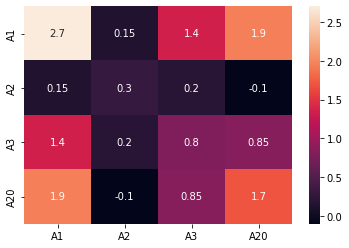

In [ ]:
import seaborn as sns
ax = sns.heatmap(x, annot = True)

In [ ]:
def CronbachAlpha_2(itemscores):
  x = itemscores.cov()

  itemscores = np.asarray(x)
  n = len(itemscores)

  ax = sns.heatmap(x, annot = True)

  principal = 0
  anti_sum = 0
  m = 0
  z = 0
  for i in range(0, n):
    for j in range(0, n):
      if (i == j):
        principal += itemscores[i][j]
        m += 1
      else:
        anti_sum += itemscores[i,j]
        z += 1
  
  anti_sum = anti_sum/2
  z = z/2

  c = anti_sum/z
  d = principal/m

  return (n*c)/(d + ((n-1)*c))

0.8205128205128205

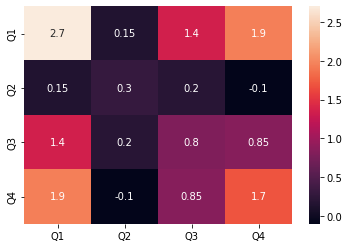

In [ ]:
CronbachAlpha_2(df)

In [ ]:

# sample data
data = {'Q1': [5,1,4,2,3], 'Q2': [1,5,2,4,3],
        'Q3':[4,2,5,3,1], 'Q4': [2,4,1,3,2]}  
df = pd.DataFrame(data)
print(df)
print()
print('The cronbach alpha is:',CronbachAlpha(df.T))

   Q1  Q2  Q3  Q4
0   5   1   4   2
1   1   5   2   4
2   4   2   5   1
3   2   4   3   3
4   3   3   1   2

number of items:  4
variance:  [2.5 2.5 2.5 1.3]
sum:  [12 12 12 12  9]
The cronbach alpha is: -5.185185185185185


-5.185185185185183

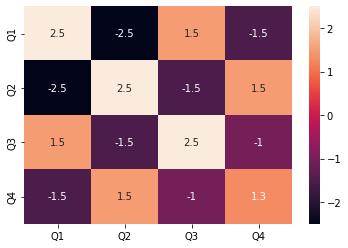

In [ ]:
CronbachAlpha_2(df)

In [ ]:
data = {'Q1': [5,5,5,5,4], 'Q2': [4,4,4,4,4],
        'Q3':[3,3,3,3,2], 'Q4': [1,1,1,1,1]}  
df = pd.DataFrame(data)
print(df)
print()
print('The cronbach alpha is:',CronbachAlpha(df.T))

   Q1  Q2  Q3  Q4
0   5   4   3   1
1   5   4   3   1
2   5   4   3   1
3   5   4   3   1
4   4   4   2   1

number of items:  4
variance:  [0.2 0.  0.2 0. ]
sum:  [13 13 13 13 11]
The cronbach alpha is: 0.6666666666666666


   A1  A2  A3  A4
0   4   5   4   5
1   3   4   3   4
2   2   3   2   3
3   1   2   1   2
4   1   2   1   2

The cronbach alpha is: 0.9999999999999999


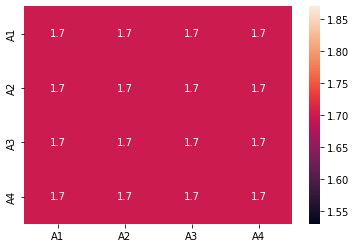

In [ ]:
data = {'A1': [4,3,2,1,1], 'A2': [5,4,3,2,2],
        'A3':[4,3,2,1,1], 'A4': [5,4,3,2,2]}  
df = pd.DataFrame(data)
print(df)
print()
print('The cronbach alpha is:',CronbachAlpha_2(df))

In [ ]:
data = {'Q1': [5,3,2,1,5], 'Q2': [1,3,2,5,5],
        'Q3':[2,5,5,3,5], 'Q4': [1,1,1,5,5]}  
df = pd.DataFrame(data)
print(df)
print()
print('The cronbach alpha is:',CronbachAlpha(df.T))

   Q1  Q2  Q3  Q4
0   5   1   2   1
1   3   3   5   1
2   2   2   5   1
3   1   5   3   5
4   5   5   5   5

number of items:  4
variance:  [3.2 3.2 2.  4.8]
sum:  [ 9 12 10 14 20]
The cronbach alpha is: 0.40701754385964906


In [ ]:
data = {'Q1': [5,3,2,1,5], 'Q2': [3,3,2,5,5],
        'Q3':[4,5,5,3,5], 'Q4': [2,1,1,5,5]}  
df = pd.DataFrame(data)
print(df)
print()
print('The cronbach alpha is:',CronbachAlpha(df.T))

   Q1  Q2  Q3
0   2   2   3
1   2   2   1
2   1   2   2
3   3   3   3
4   1   1   2
5   1   1   1
6   1   2   2

The cronbach alpha is: 0.8313253012048193


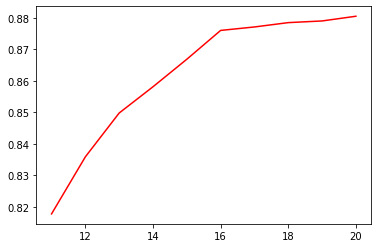

In [ ]:
#similar to what is done in CS Project - annotation analysis
#last 5 annotators are noise
core = [0,1,5,6,7,10,11,12,13,14,15,16,17,18,19] 
chosen = []
lst_1 = []
for i in range(15):
  if i < 10:
    random_num = random.choice(core)
    chosen.append(random_num)
  else:
    random_num = random.choice(core)
    chosen.append(random_num)
    test_df = master_df[chosen]
    lst_1.append(CronbachAlpha(test_df.T))
for j in [1, 6, 2, 8, 9]:
  chosen.append(j)
  test_df = master_df[chosen]
  lst_1.append(CronbachAlpha(test_df.T))
plt.plot([l for l in range(11,21)],lst_1,color = 'red')

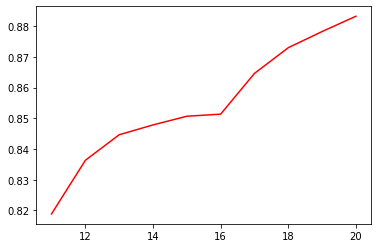

In [ ]:
#similar to what is done in CS Project - annotation analysis
#randomly chosen annotators
all = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
chosen = []
lst = []
for i in range(20):
  if i < 10:
    random_num = random.choice(all)
    chosen.append(random_num)
  else:
    random_num = random.choice(all)
    chosen.append(random_num)
    test_df = master_df[chosen]
    lst.append(CronbachAlpha(test_df.T))
plt.plot([l for l in range(11,21)],lst,color = 'red')

Chronbach Alpha for each segment for video 1


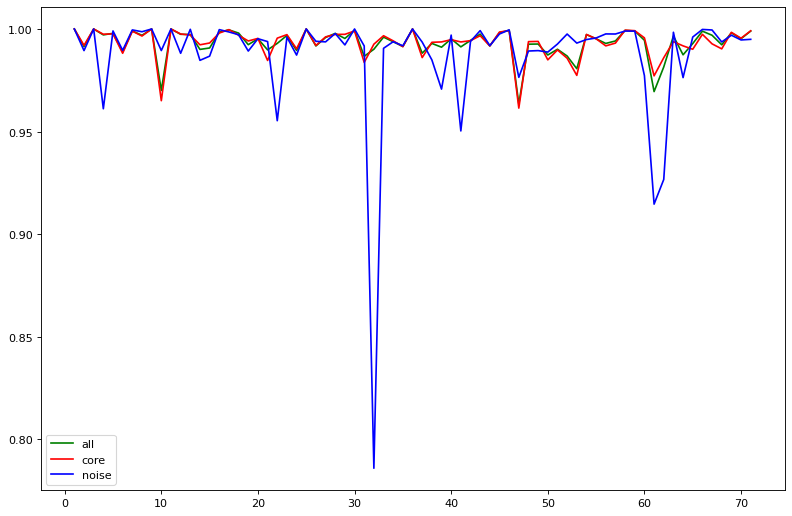

Chronbach Alpha for each segment for video 2


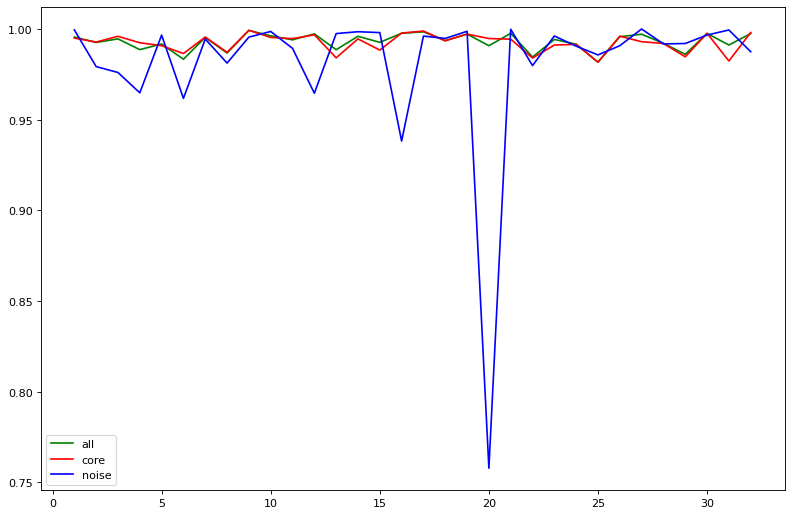

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


Chronbach Alpha for each segment for video 3


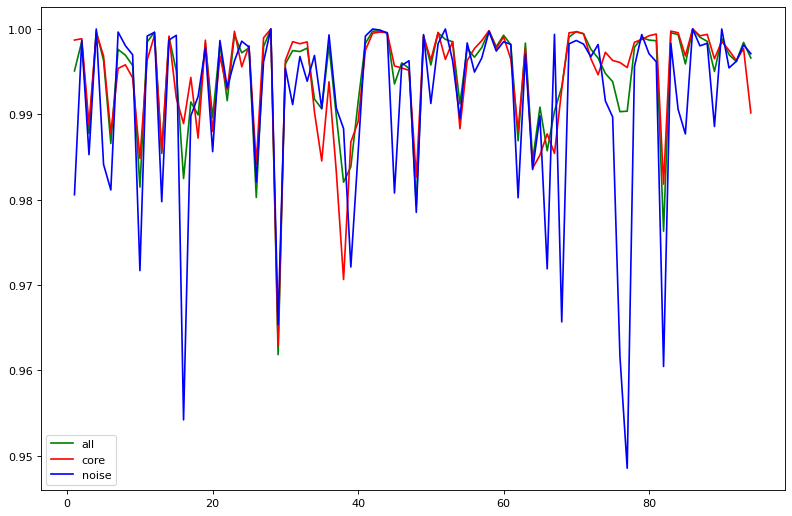

Chronbach Alpha for each segment for video 4


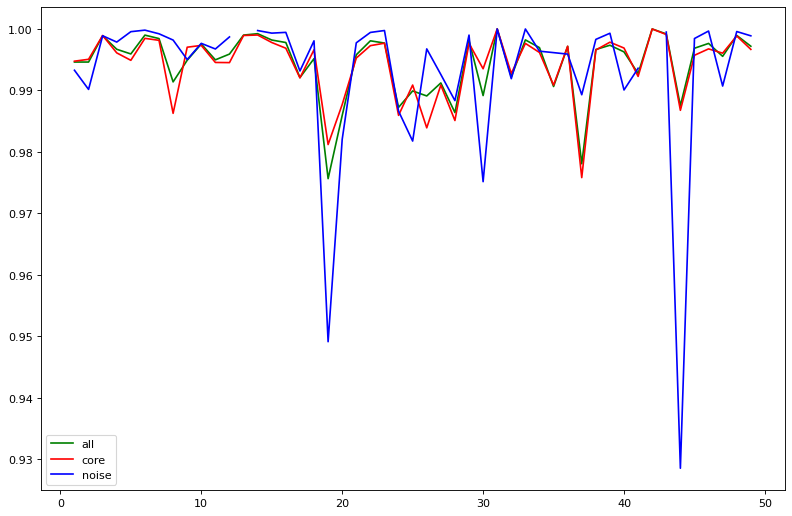

Chronbach Alpha for each segment for video 5


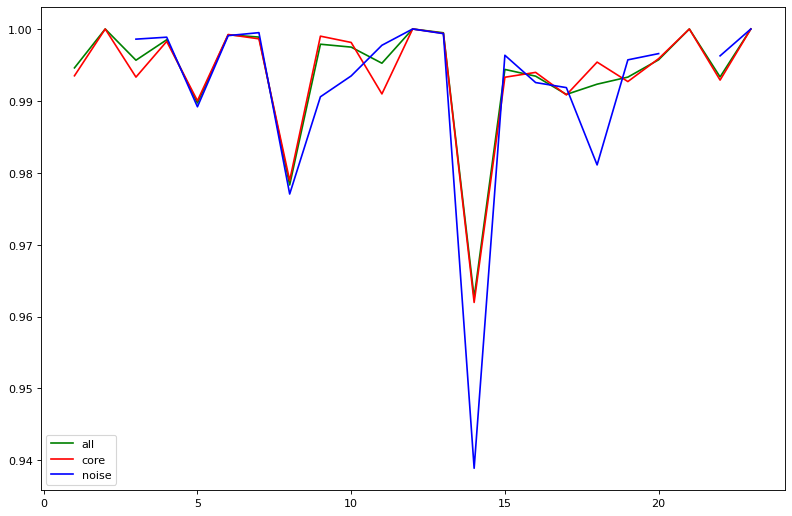

Chronbach Alpha for each segment for video 6


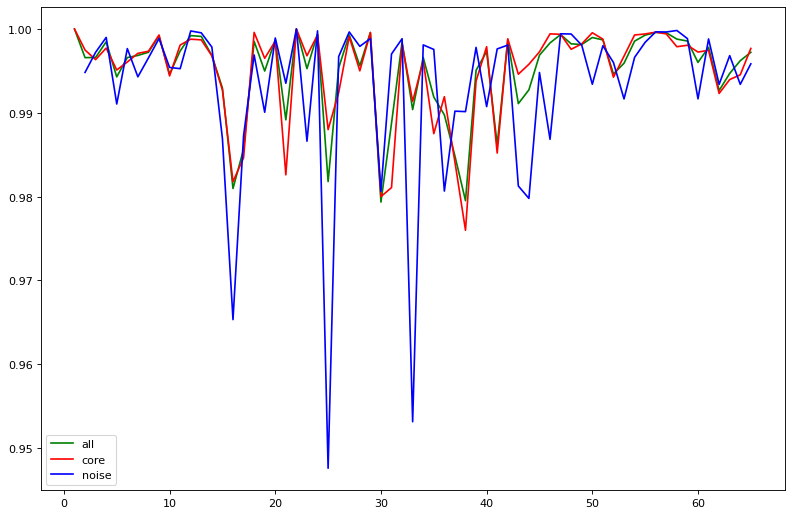

Chronbach Alpha for each segment for video 7


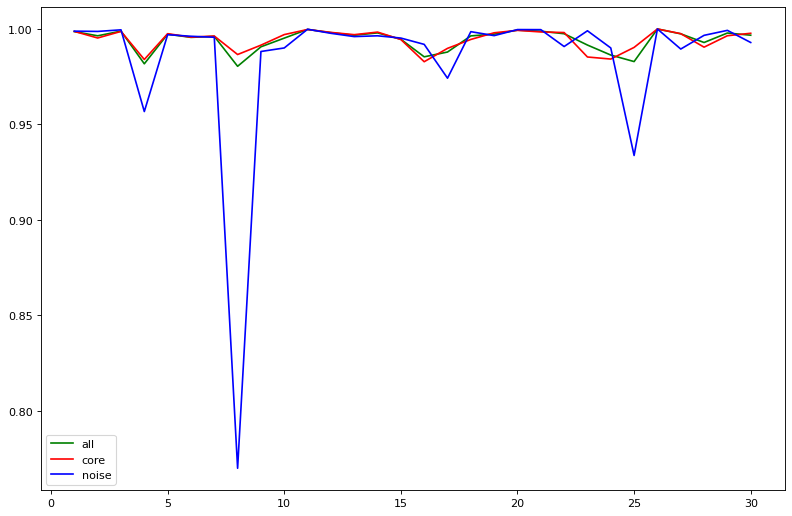

Chronbach Alpha for each segment for video 8


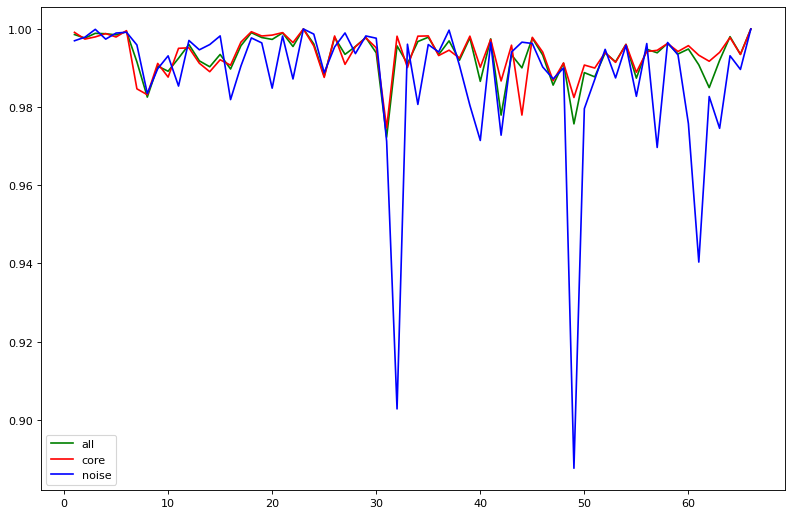

Chronbach Alpha for each segment for video 9


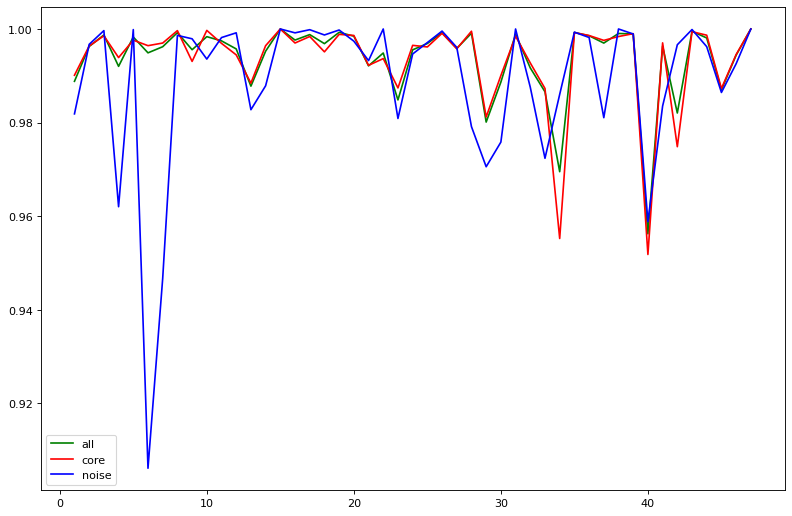

Chronbach Alpha for each segment for video 10


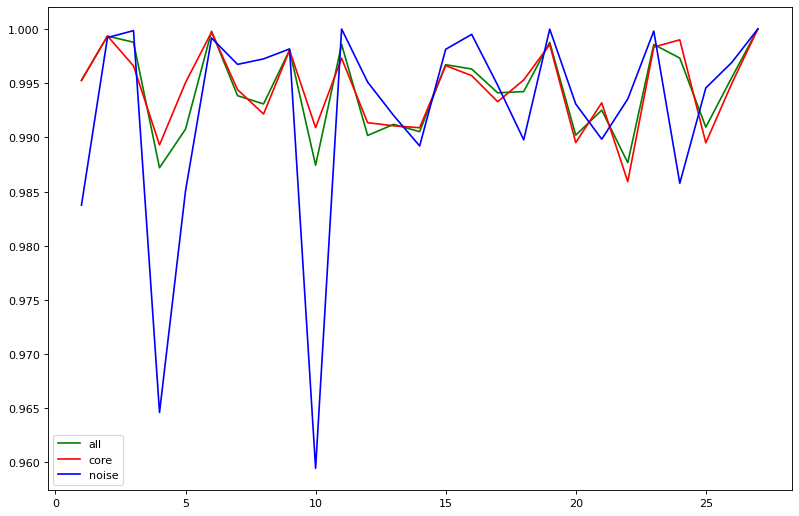

Chronbach Alpha for each segment for video 11


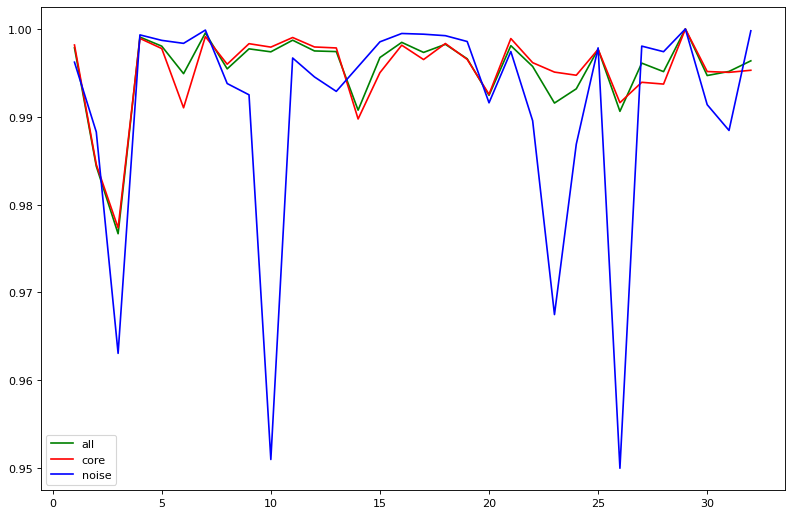

Chronbach Alpha for each segment for video 12


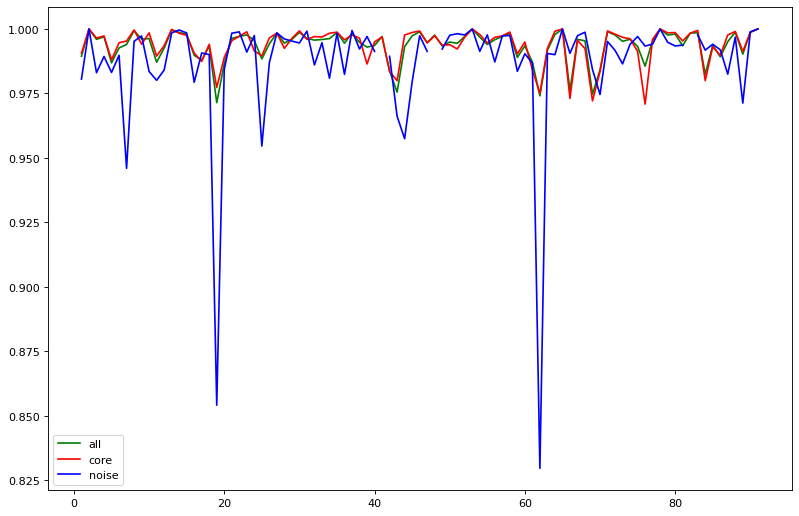

Chronbach Alpha for each segment for video 13


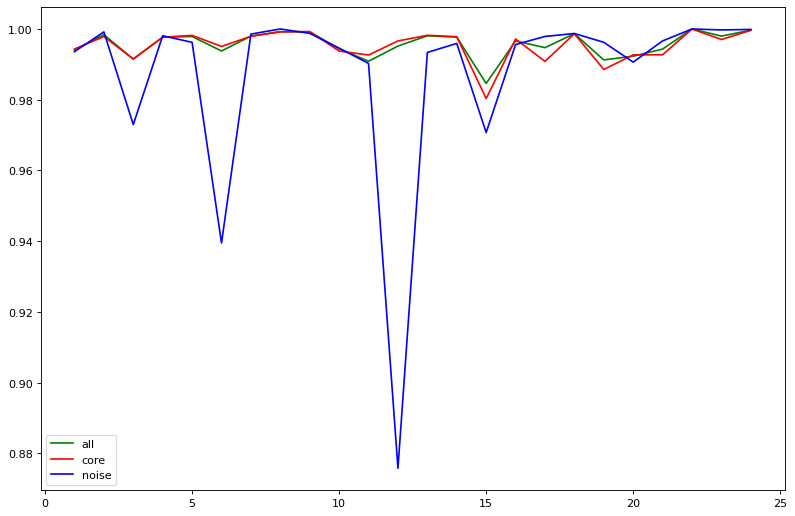

Chronbach Alpha for each segment for video 14


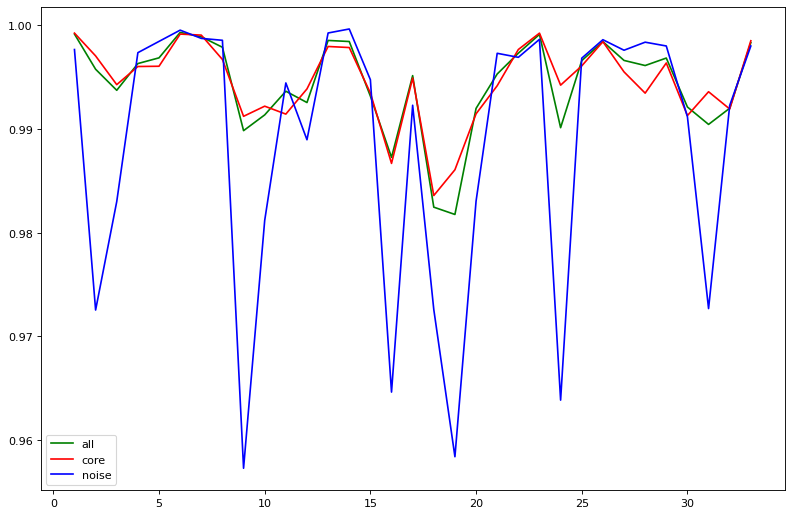

Chronbach Alpha for each segment for video 15


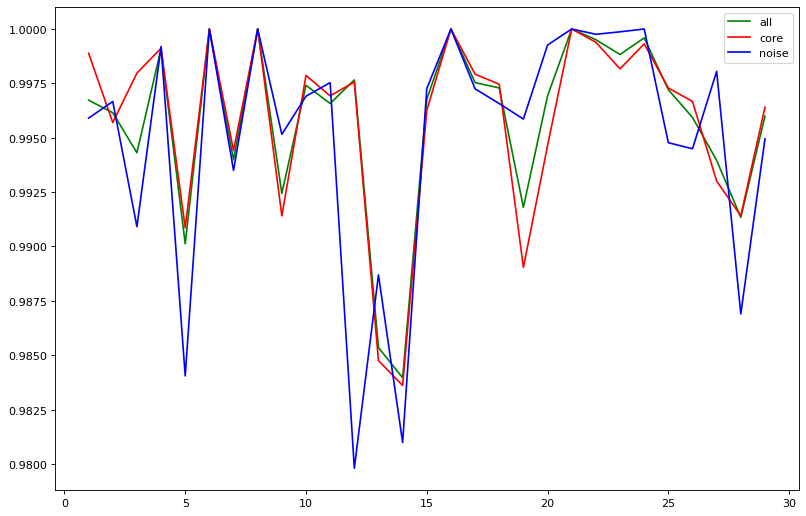

Chronbach Alpha for each segment for video 16


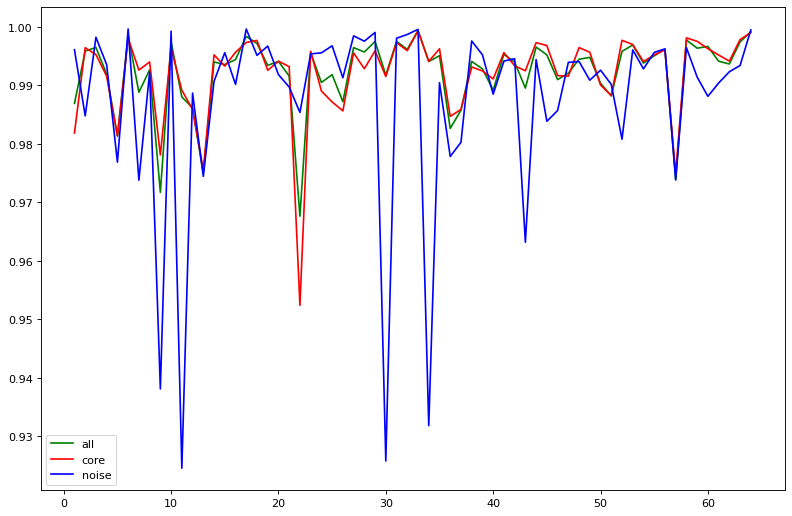

Chronbach Alpha for each segment for video 17


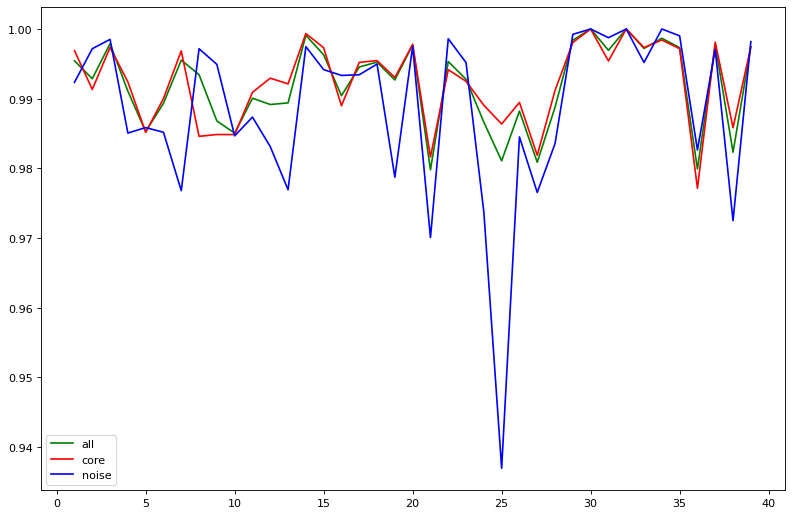

Chronbach Alpha for each segment for video 18


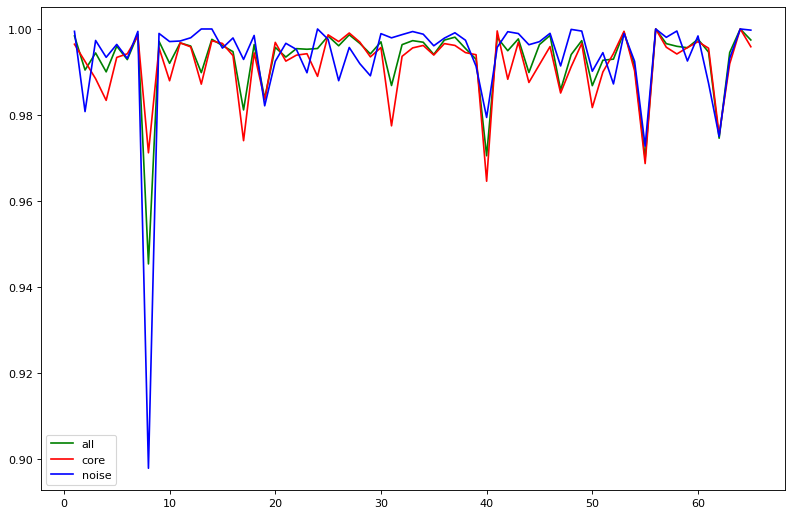

Chronbach Alpha for each segment for video 19


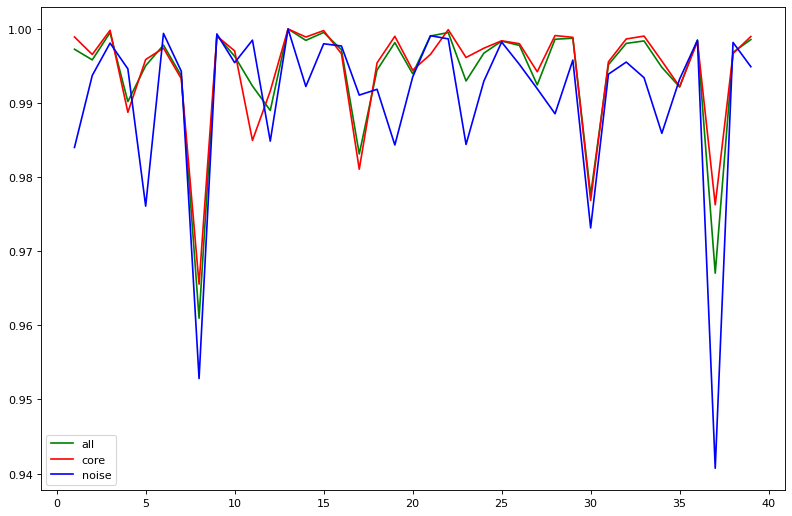

Chronbach Alpha for each segment for video 20


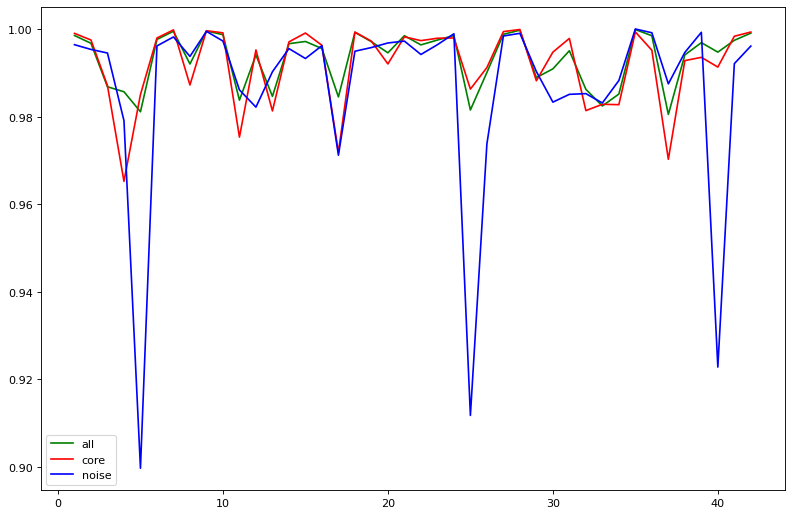

Chronbach Alpha for each segment for video 21


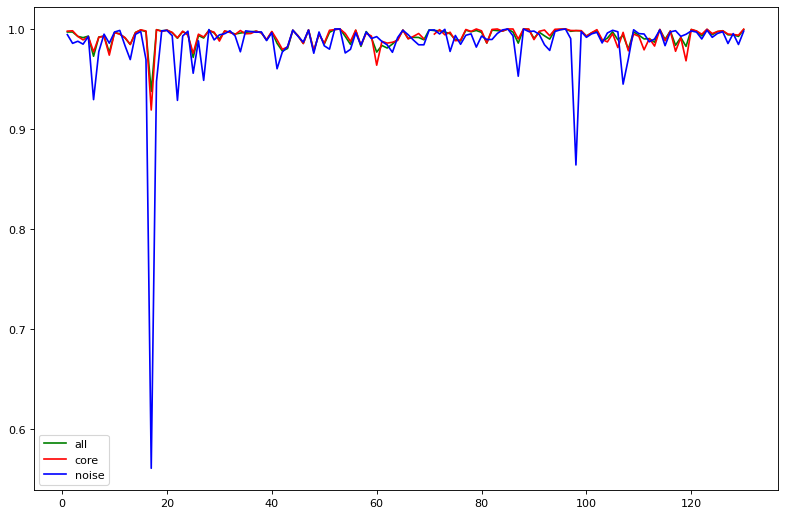

Chronbach Alpha for each segment for video 22


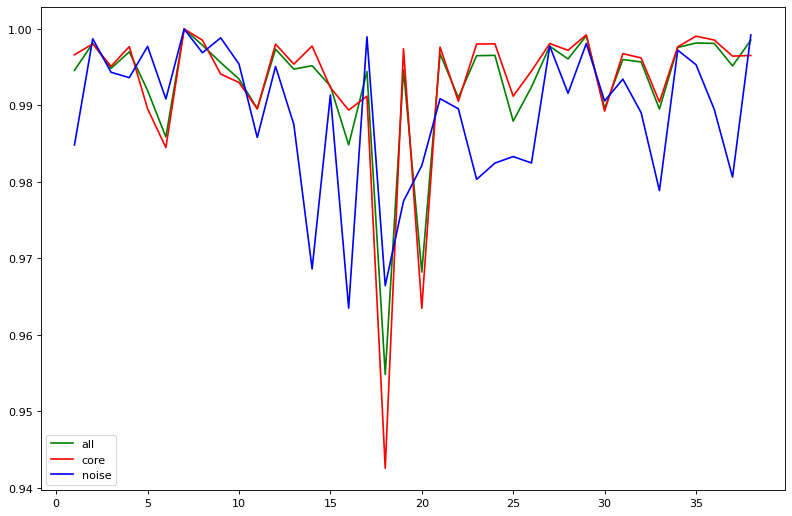

Chronbach Alpha for each segment for video 23


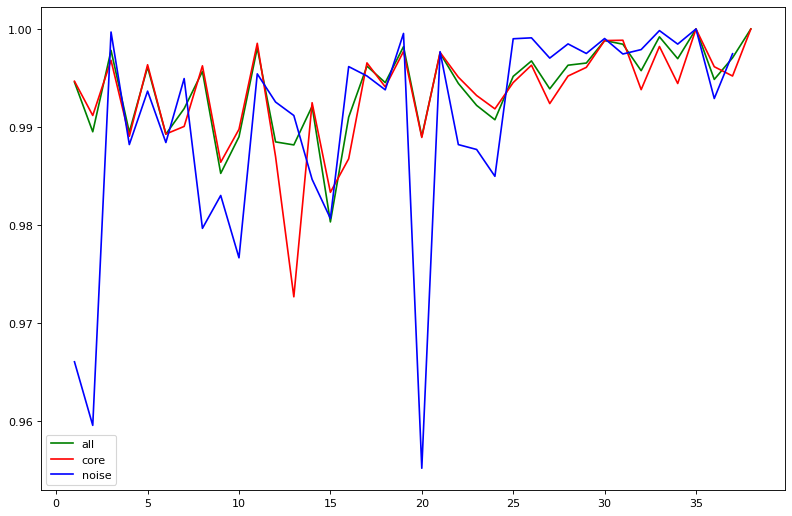

Chronbach Alpha for each segment for video 24


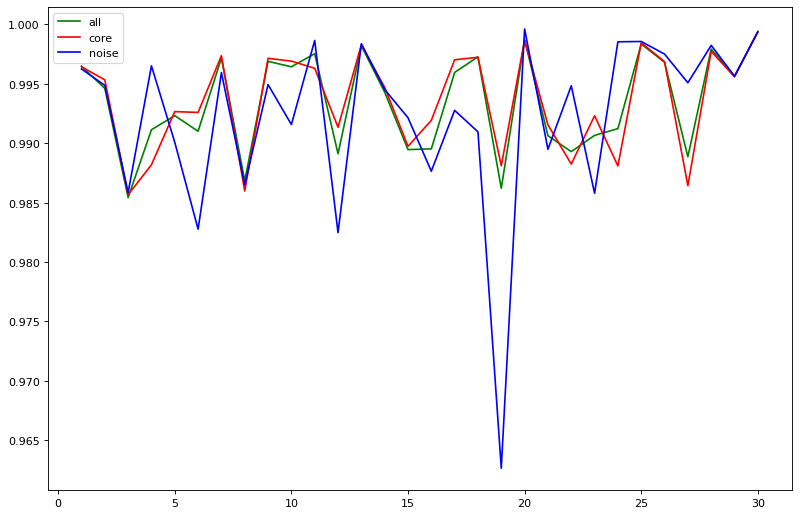

Chronbach Alpha for each segment for video 25


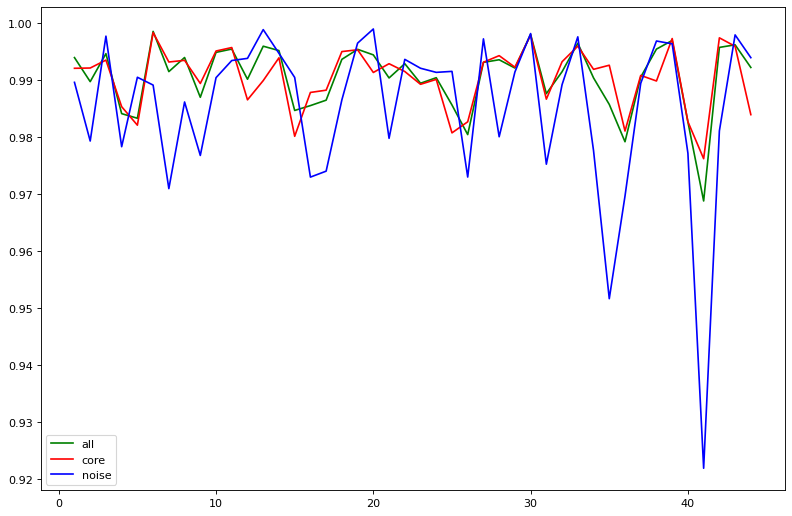

Chronbach Alpha for each segment for video 26


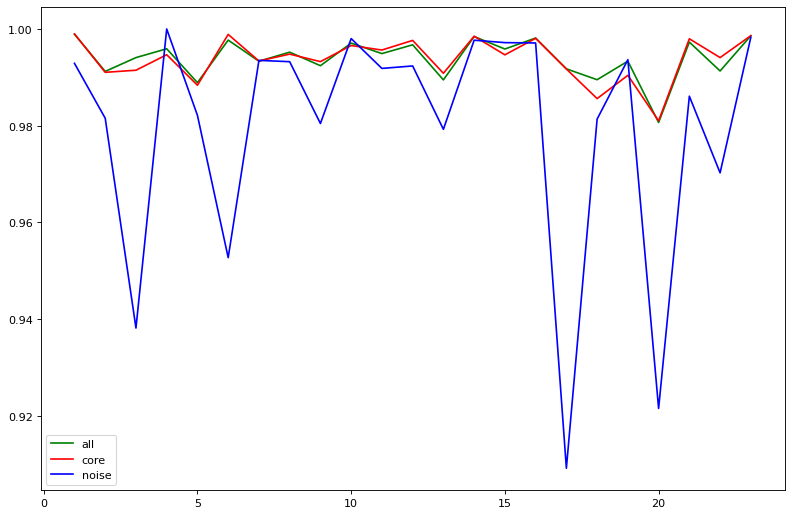

Chronbach Alpha for each segment for video 27


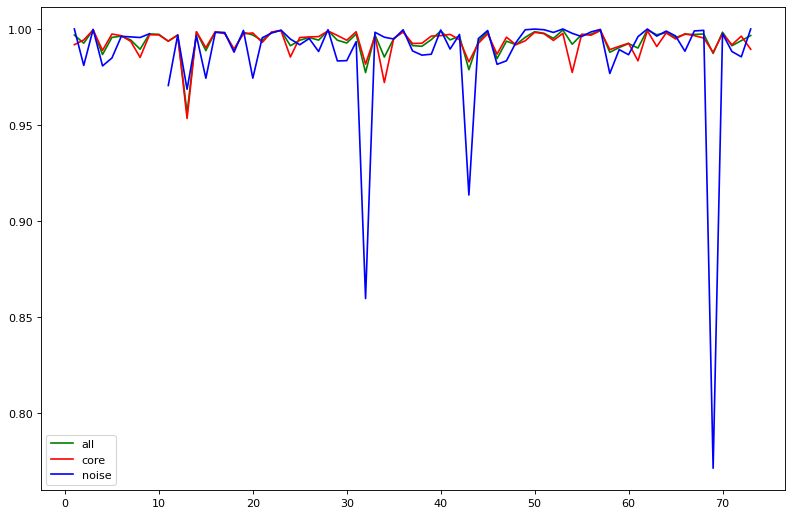

Chronbach Alpha for each segment for video 28


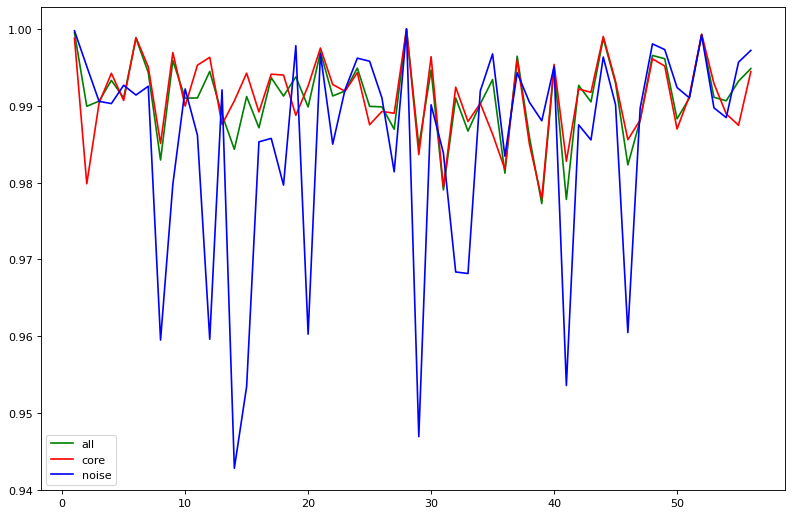

Chronbach Alpha for each segment for video 29


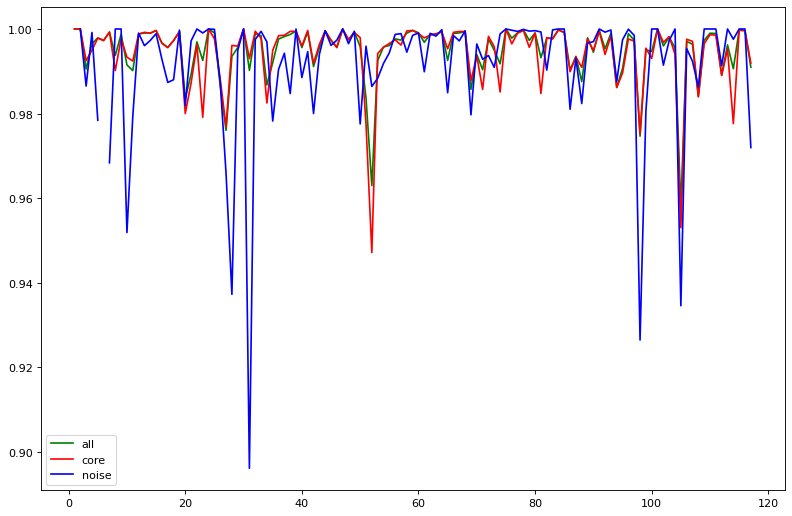

Chronbach Alpha for each segment for video 30


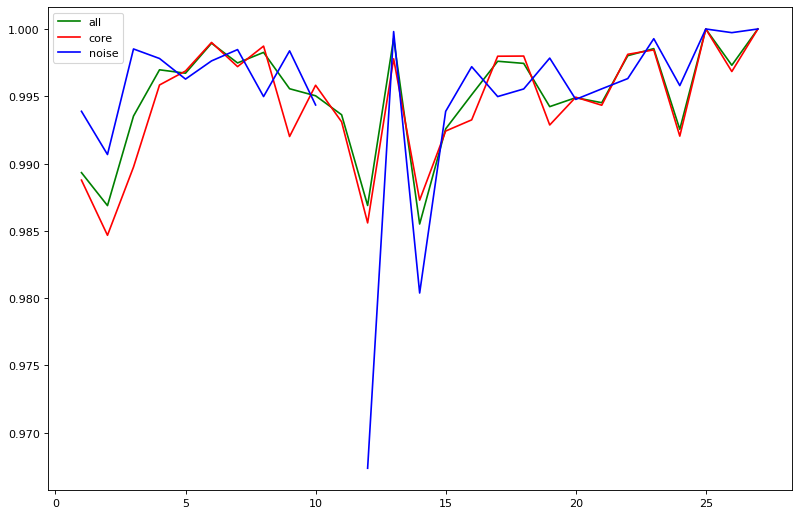

Chronbach Alpha for each segment for video 31


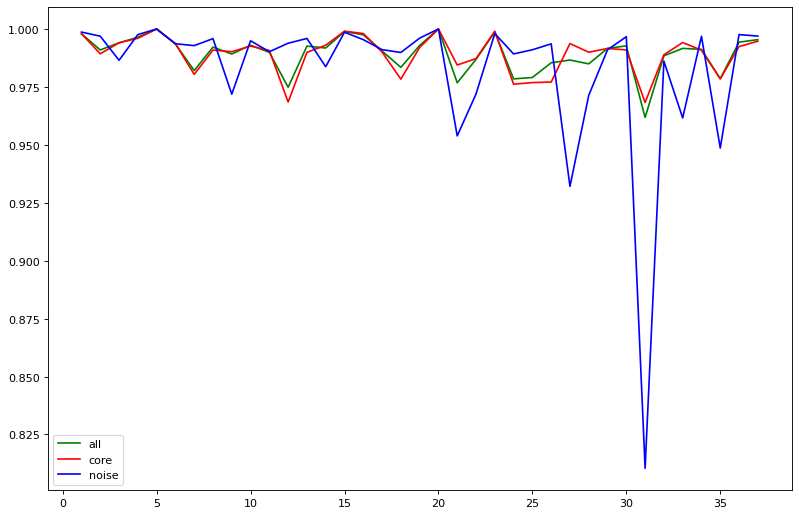

Chronbach Alpha for each segment for video 32


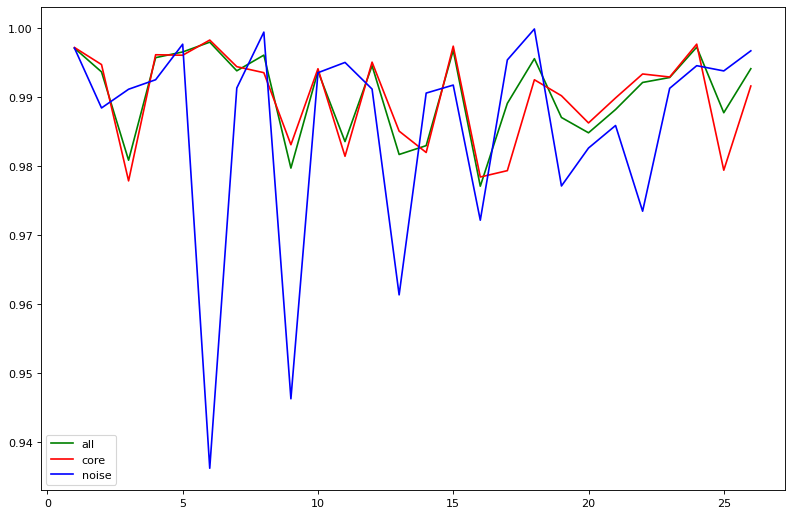

Chronbach Alpha for each segment for video 33


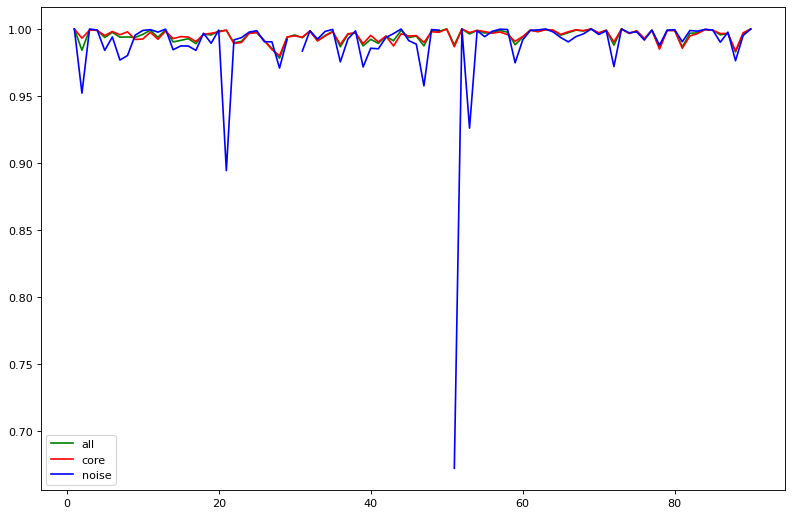

Chronbach Alpha for each segment for video 34


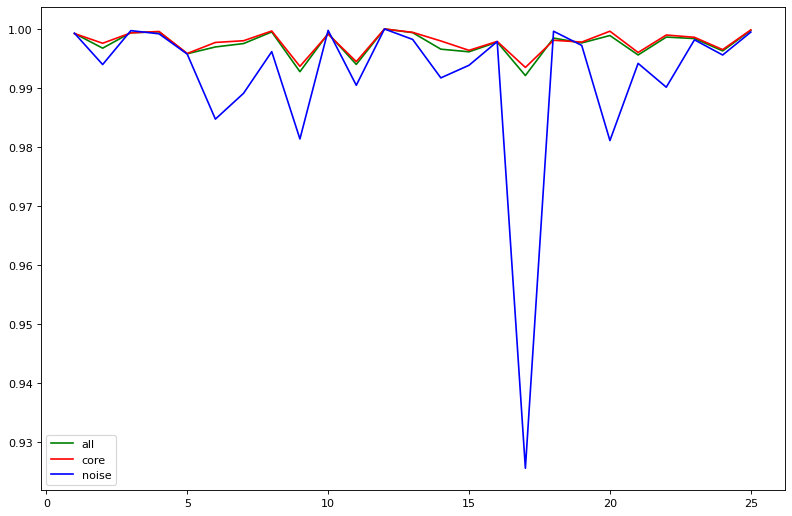

Chronbach Alpha for each segment for video 35


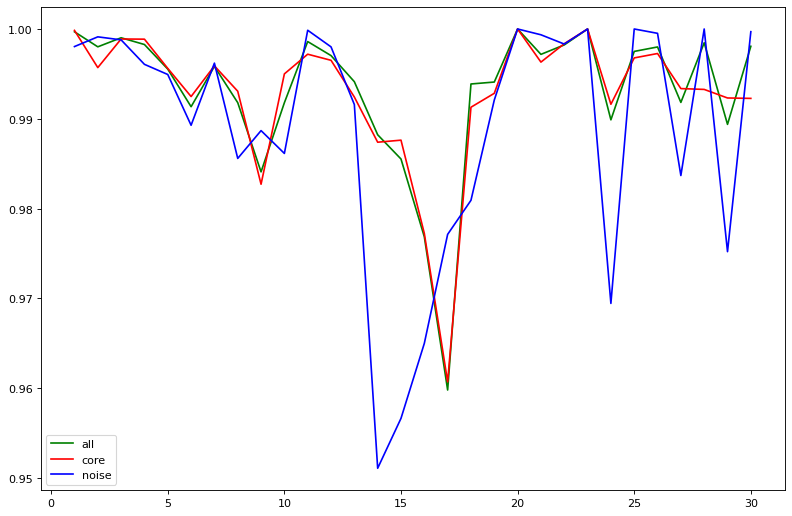

Chronbach Alpha for each segment for video 36


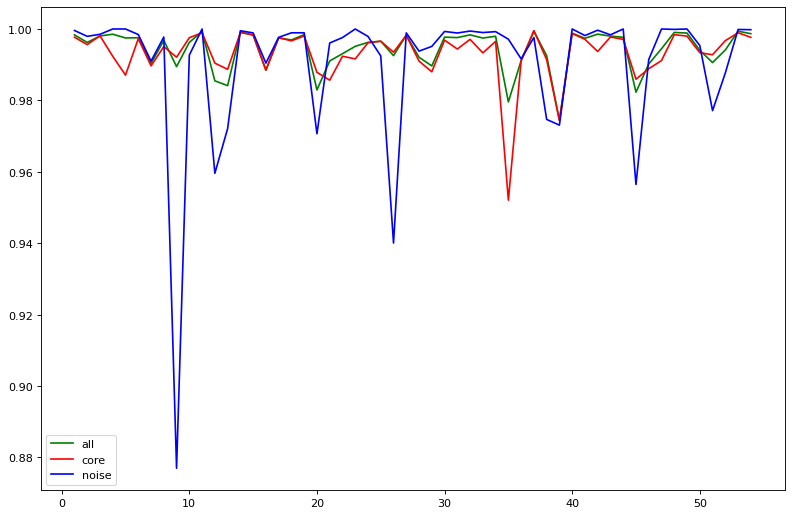

Chronbach Alpha for each segment for video 37


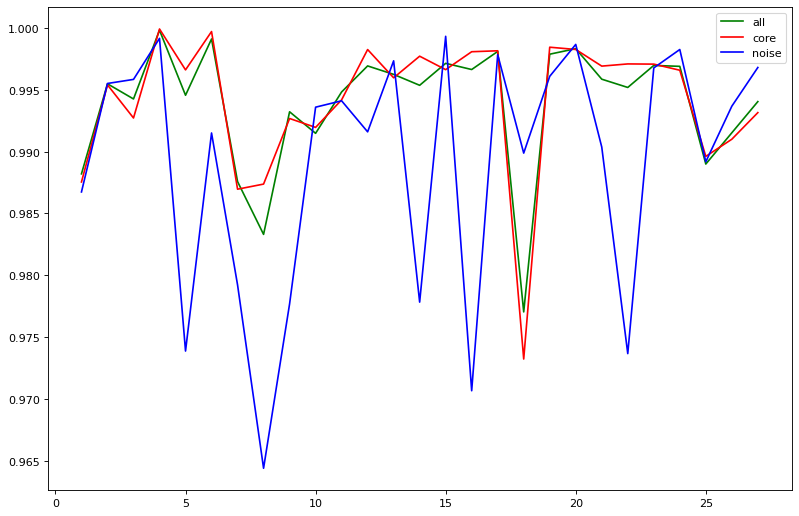

Chronbach Alpha for each segment for video 38


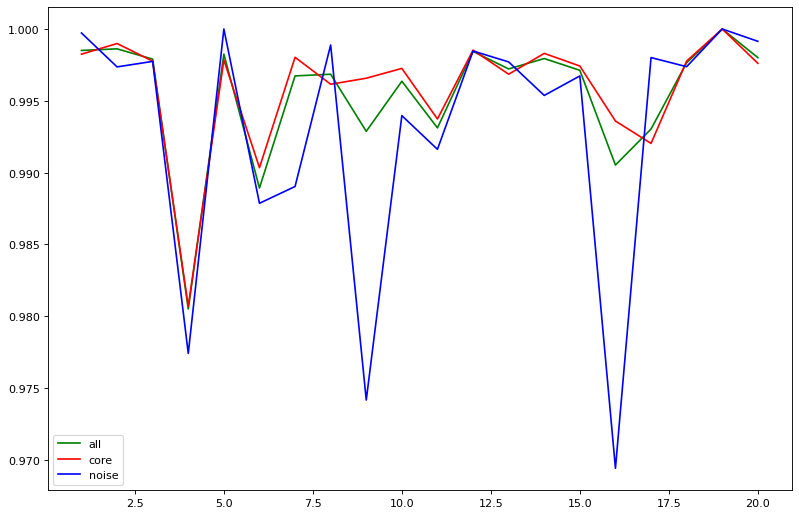

Chronbach Alpha for each segment for video 39


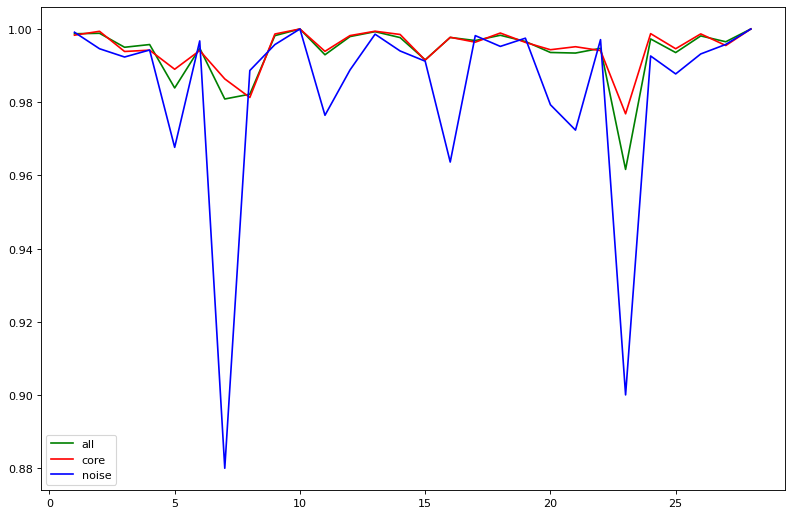

Chronbach Alpha for each segment for video 40


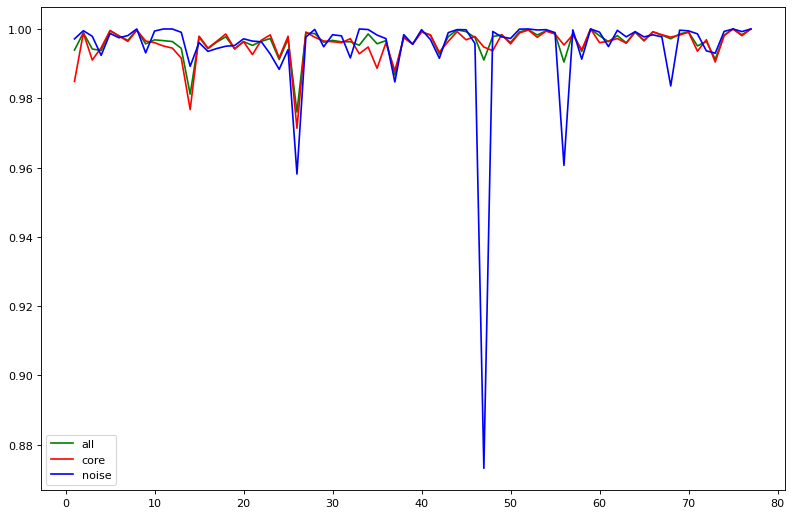

Chronbach Alpha for each segment for video 41


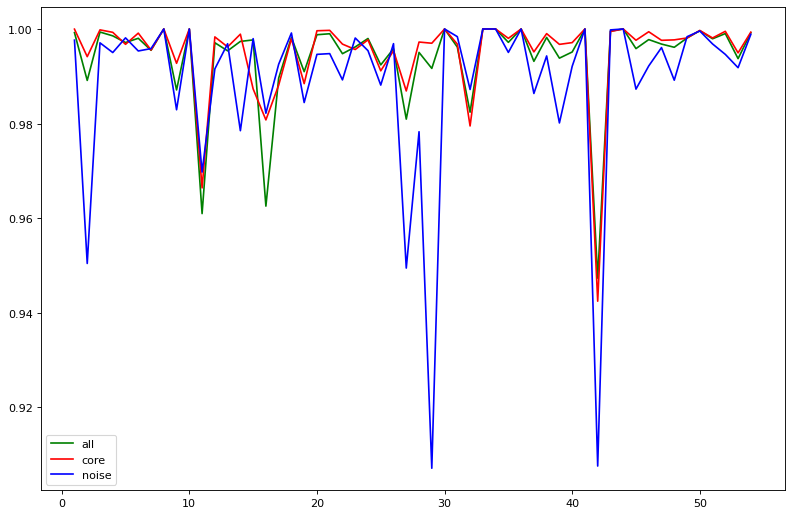

Chronbach Alpha for each segment for video 42


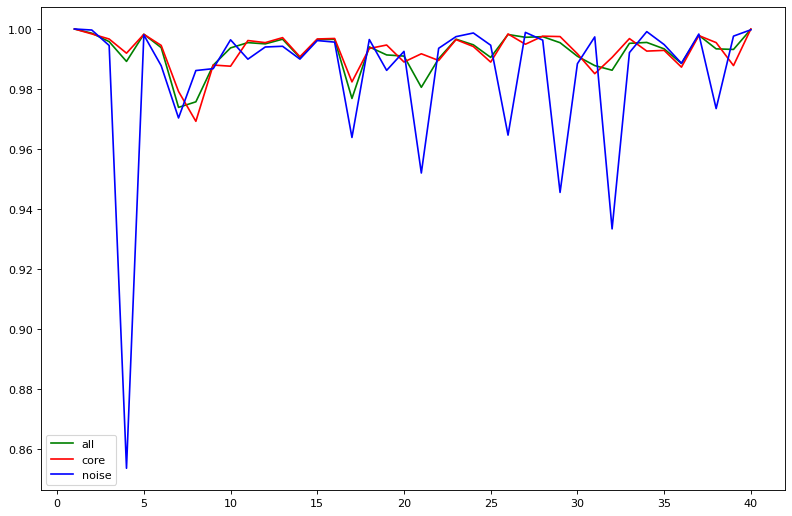

Chronbach Alpha for each segment for video 43


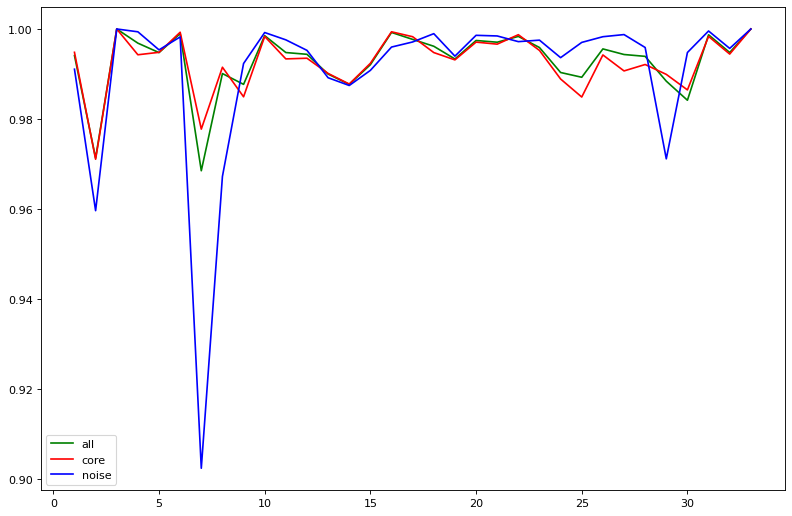

Chronbach Alpha for each segment for video 44


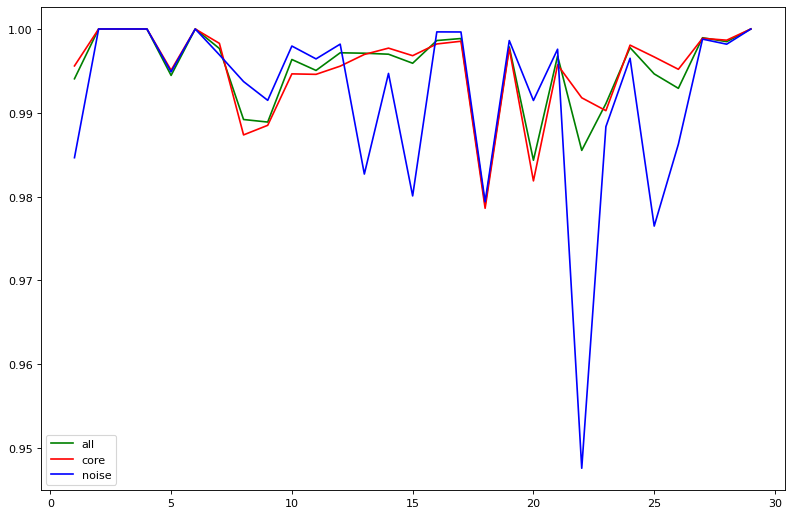

Chronbach Alpha for each segment for video 45


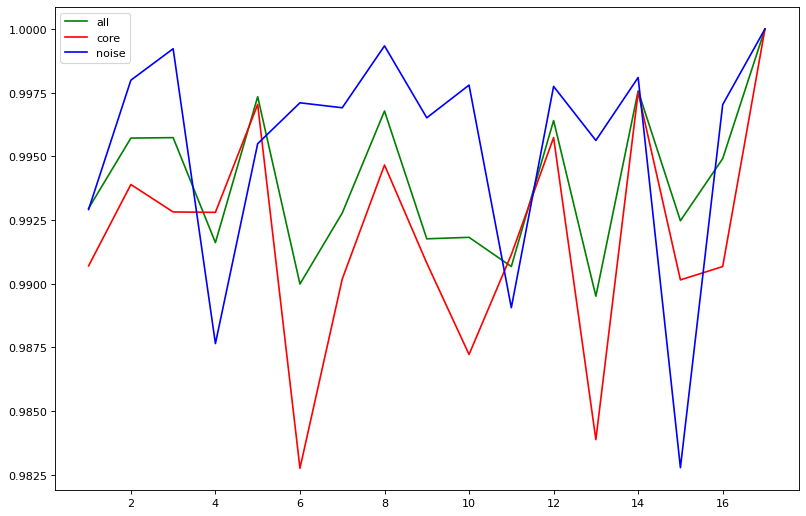

Chronbach Alpha for each segment for video 46


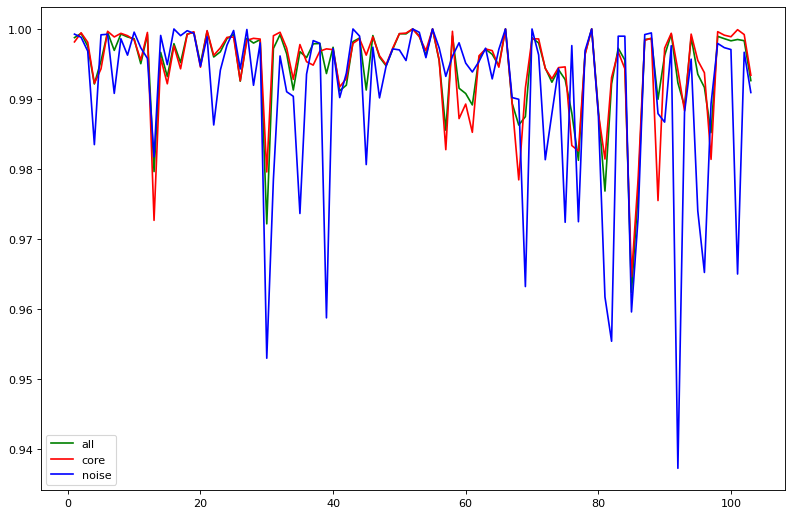

Chronbach Alpha for each segment for video 47


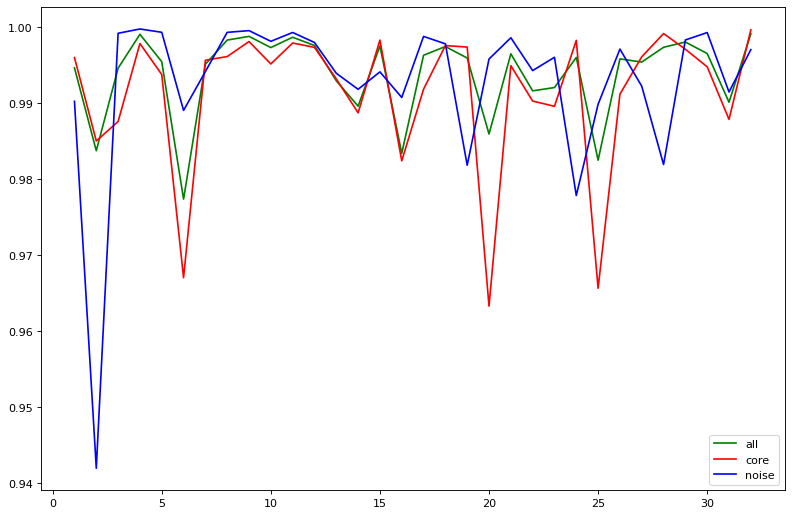

Chronbach Alpha for each segment for video 48


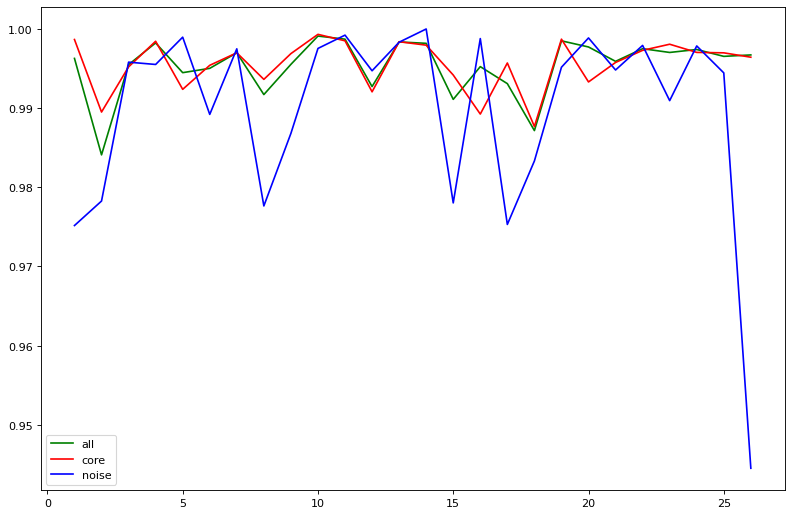

Chronbach Alpha for each segment for video 49


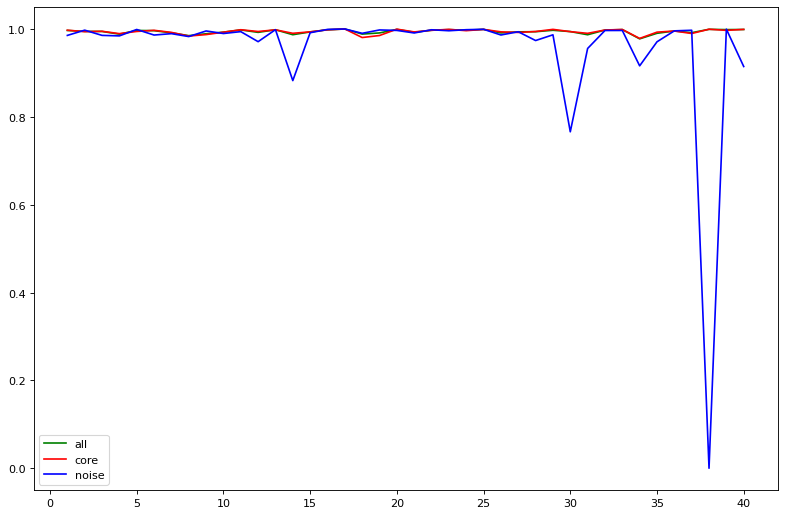

Chronbach Alpha for each segment for video 50


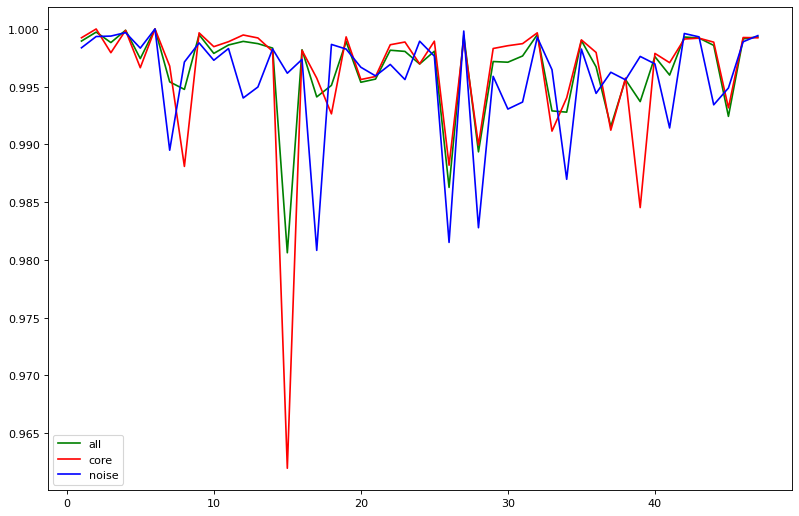

In [ ]:
#plotting cronbach alpha for each segment of each video
#every graph is cronbach alpha of each segment for a particular video
for z in range(1,51):
  df = pd.read_excel(open('tvsum50.xlsx', 'rb'),sheet_name=z, header=None).iloc[:,0:20] #opening the corresponding annotation workbook
  video_change_points = [ item for elem in change_points[:][z-1] for item in elem] #getting the change points
  video_segments = []
  for i in range(0,len(video_change_points),2): #converting the change points into a nested list
    video_segments.append([video_change_points[i],video_change_points[i+1]]) 
  chron_list = []
  chron_list_core = []
  chron_list_noise = []
  chron_list_cluster = []
  noise,cluster = 0,0
  for k in video_segments:
    chron_df  = df.iloc[k[0]:k[1]+1] #calculating the cronbach alpha for each segment
    chron_df_core = df.iloc[k[0]:k[1]+1,[0, 3, 4, 5, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]] #chronbach alpha for core points acc. to DBSCAN
    chron_df_noise = df.iloc[k[0]:k[1]+1,[1, 2, 6, 8, 9]] #cronbach alpha for noise points according to DBSCAN
    chron_df_cluster = df.iloc[k[0]:k[1]+1,[ 0, 5, 11, 4, 7]] #cronbach alpha -- can be used as reference
    chron_list.append(CronbachAlpha(chron_df))
    chron_list_core.append(CronbachAlpha(chron_df_core))
    chron_list_noise.append(CronbachAlpha(chron_df_noise))
    chron_list_cluster.append(CronbachAlpha(chron_df_cluster))
  print("Chronbach Alpha for each segment for video",z)
  figure(figsize=(12, 8), dpi=80)
  plt.plot([l for l in range(1,len(chron_list)+1)],chron_list,color = 'green',label = 'all') #plotting the data
  plt.plot([l for l in range(1,len(chron_list)+1)],chron_list_core,color = 'red',label = 'core') 
  plt.plot([l for l in range(1,len(chron_list)+1)],chron_list_noise,color = 'blue',label = 'noise') 
  #plt.plot([l for l in range(1,len(chron_list)+1)],chron_list_cluster,color = 'black',label = 'cluster') 
  plt.legend()
  plt.show()

## DBSCAN 

In [ ]:
# Computing DBSCAN
db = DBSCAN(eps=56,min_samples = 4).fit(master_df.T)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 5


In [ ]:
noise = []
core = []
for i in range(len(labels)):
  if labels[i] == 0:
    core.append(i)
  else:
    noise.append(i)
print("The annotators classified as noise: ",noise)
print("The annotators classified into a cluster",core) 

The annotators classified as noise:  [1, 2, 6, 8, 9]
The annotators classified into a cluster [0, 3, 4, 5, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [ ]:
#plotting standard deviation and GT score for all annotators excluding noise
#data can be plotted using GT_score_core.
#see CS Project - annotation analysis as reference
core = [0, 3, 4, 5, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
GT_score_core = []
stdev_core_GT = []
for i in range(1,2373):
  total = 0
  abc = []
  for j in core:
    number = master_df.iloc[i][j]
    total += number
    abc.append(number)
  stdev_core_GT.append(np.std(abc))
  GT_score_core.append(total/len(core))
statistics.mean(stdev_core_GT)

0.7598011666570633

In [ ]:
#plotting standard deviation and GT score for all annotators
all = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
GT_score = []
stdev_all_GT = []
for i in range(1,2373):
  total = 0
  abc = []
  for j in all:
    number = master_df.iloc[i][j]
    total += number
    abc.append(number)
  stdev_all_GT.append(np.std(abc))
  GT_score.append(total/len(all))
statistics.mean(stdev_all_GT)

0.7851396677316795

In [ ]:
#plotting standard deviation and GT score for all annotators categorized as noise
noise_segment = [1, 2, 6, 8, 9]
GT_score_noise_segment = []
stdev_noise_segment_GT = []
for i in range(1,2373):
  total = 0
  abc = []
  for j in noise_segment:
    number = master_df.iloc[i][j]
    total += number
    abc.append(number)
  stdev_noise_segment_GT.append(np.std(abc))
  GT_score_noise_segment.append(total/len(noise_segment))
statistics.mean(stdev_noise_segment_GT)

0.7046905233459302

## Hierarchical clustering

In [ ]:
dendrogram = sch.linkage(master_df.T, method  = "single",optimal_ordering = True)
print(dendrogram)
# noise is all data [2, 3, 4, 8, 9]
# noise for segment data [1, 6, 2, 8, 9]

[[ 0.         18.         53.24815979  2.        ]
 [20.         11.         53.89243906  3.        ]
 [ 7.         15.         54.37197575  2.        ]
 [14.         10.         54.49065005  2.        ]
 [ 5.         13.         54.93733504  2.        ]
 [ 3.         12.         55.12657482  2.        ]
 [19.         23.         55.28736595  3.        ]
 [24.         22.         55.32563633  4.        ]
 [17.         21.         55.33471138  4.        ]
 [26.         28.         55.41409405  7.        ]
 [29.         25.         55.41577476  9.        ]
 [27.         30.         55.42526505 13.        ]
 [31.          4.         55.67684138 14.        ]
 [16.         32.         55.75041862 15.        ]
 [33.          9.         56.57402496 16.        ]
 [34.          1.         56.70253933 17.        ]
 [ 6.         35.         56.96627337 18.        ]
 [36.          8.         57.67904571 19.        ]
 [ 2.         37.         57.69594453 20.        ]]


In [ ]:
dendrogram = sch.linkage(df.T, method  = "single",optimal_ordering = True)
print(dendrogram)

[[ 17.          13.          63.49803147   2.        ]
 [ 16.          20.          67.17142249   3.        ]
 [ 21.          14.          79.44809626   4.        ]
 [ 19.          15.          79.7746827    2.        ]
 [ 22.          23.          80.50465825   6.        ]
 [ 18.           4.          86.66602564   2.        ]
 [  0.          24.          88.31760866   7.        ]
 [ 25.          26.          90.39358384   9.        ]
 [ 27.           5.          91.          10.        ]
 [ 28.           2.          95.81753493  11.        ]
 [ 12.          29.          96.75226096  12.        ]
 [ 30.           1.          97.37042672  13.        ]
 [ 10.          31.          97.71898485  14.        ]
 [ 32.           9.         101.          15.        ]
 [  3.          33.         107.94443015  16.        ]
 [  7.          34.         108.21737384  17.        ]
 [  6.          35.         108.70602559  18.        ]
 [ 11.          36.         117.02563822  19.        ]
 [  8.    

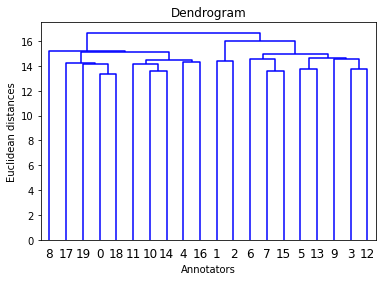

In [ ]:
#Hierarchial clustering for segment data
dendrogram = sch.dendrogram(sch.linkage(master_scaled_df.T, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Annotators')
plt.ylabel('Euclidean distances')
plt.show()

In [ ]:
random_lists = [[1, 4, 10, 18, 5, 19, 8, 17, 14, 15, 16, 6, 2, 9, 0],[12, 19, 2, 6, 17, 16, 10, 14, 8, 5, 1, 4, 7, 9, 13],[7, 9, 2, 0, 11, 15, 19, 5, 4, 17, 3, 18, 1, 16, 10] ,
[2, 13, 11, 1, 18, 16, 6, 17, 9, 4, 7, 12, 14, 10, 3] ,[3, 4, 1, 9, 17, 8, 7, 12, 16, 10, 5, 19, 18, 11, 6] ,
[9, 0, 11, 12, 15, 14, 18, 17, 10, 4, 8, 6, 16, 19, 7],[11, 9, 18, 14, 12, 1, 19, 0, 6, 7, 15, 3, 17, 2, 8] ,
[9, 11, 1, 12, 2, 0, 19, 16, 10, 4, 15, 18, 6, 17, 5] ,
[19, 17, 9, 13, 3, 14, 0, 18, 6, 15, 2, 7, 5, 11, 10] ,
[13, 15, 7, 0, 14, 16, 5, 2, 9, 12, 17, 19, 1, 8, 18], [10, 9, 0, 12, 6, 8, 5, 18, 19, 4, 1, 7, 16, 2, 3] ,[1, 3, 14, 4, 15, 8, 2, 12, 18, 13, 6, 5, 17, 9, 16],
[9, 0, 13, 16, 11, 4, 14, 2, 7, 5, 8, 19, 12, 10, 6],[12, 2, 13, 15, 17, 6, 9, 8, 19, 10, 18, 3, 0, 4, 11],[16, 17, 3, 4, 6, 12, 1, 8, 0, 19, 10, 14, 9, 7, 15] ,
[10, 14, 13, 3, 2, 1, 11, 0, 16, 6, 12, 9, 19, 7, 4] ,[6, 2, 18, 14, 10, 16, 19, 8, 3, 7, 17, 11, 1, 0, 13],[9, 16, 19, 10, 6, 18, 1, 14, 4, 5, 7, 3, 15, 8, 2] ,
[16, 4, 10, 5, 17, 3, 11, 0, 13, 1, 19, 12, 14, 2, 8],[5, 9, 6, 10, 14, 16, 15, 11, 4, 3, 12, 13, 1, 18, 0],
[18, 7, 5, 19, 1, 0, 3, 2, 9, 17, 11, 6, 8, 14, 4] ,[18, 6, 7, 0, 16, 19, 4, 14, 8, 15, 1, 12, 5, 9, 3],
[19, 3, 5, 11, 8, 13, 1, 4, 7, 16, 0, 2, 14, 15, 18],[19, 5, 2, 3, 10, 14, 12, 1, 8, 17, 7, 6, 4, 0, 13] ,[7, 5, 8, 3, 6, 15, 9, 10, 4, 12, 19, 11, 18, 0, 13],
[19, 16, 2, 7, 11, 15, 13, 5, 10, 0, 14, 18, 8, 1, 9],[1, 10, 16, 7, 15, 3, 6, 14, 18, 5, 11, 19, 8, 9, 12],
[14, 3, 10, 16, 7, 2, 15, 5, 4, 12, 0, 8, 9, 6, 1] ,
[11, 2, 1, 10, 17, 6, 3, 14, 8, 19, 5, 12, 9, 18, 7],
[2, 11, 7, 17, 15, 16, 10, 1, 8, 6, 12, 4, 18, 3, 0],
[2, 1, 4, 0, 6, 16, 17, 14, 9, 8, 18, 5, 7, 3, 15] ,
[19, 18, 1, 3, 8, 4, 14, 13, 10, 2, 0, 17, 6, 7, 5],
[19, 15, 16, 1, 4, 10, 18, 13, 17, 8, 7, 14, 12, 0, 6] ,
[6, 13, 16, 17, 4, 9, 12, 3, 1, 7, 14, 18, 19, 11, 0] ,
[9, 18, 1, 5, 19, 14, 11, 4, 17, 8, 16, 12, 10, 3, 7], 
[5, 0, 15, 4, 2, 18, 1, 19, 7, 14, 8, 12, 3, 9, 16] ,
[17, 0, 8, 14, 3, 13, 16, 10, 1, 4, 15, 6, 11, 5, 9],
[5, 0, 14, 7, 19, 6, 4, 18, 2, 8, 17, 9, 12, 3, 11] ,
[7, 13, 12, 11, 15, 2, 18, 14, 8, 16, 19, 1, 6, 0, 10],[13, 0, 6, 15, 12, 2, 3, 18, 17, 11, 1, 9, 8, 4, 7] ,[4, 9, 15, 3, 1, 16, 6, 14, 18, 10, 17, 5, 7, 2, 0] ,[8, 16, 14, 4, 13, 15, 11, 17, 10, 0, 5, 7, 12, 9, 6] ,
[18, 12, 5, 13, 8, 16, 3, 15, 4, 1, 19, 11, 10, 7, 0] ,
[16, 4, 8, 11, 9, 0, 6, 13, 5, 15, 3, 2, 12, 17, 7],[18, 3, 5, 17, 19, 6, 11, 7, 0, 16, 12, 1, 8, 10, 15],[5, 10, 15, 8, 13, 1, 16, 17, 0, 7, 12, 3, 18, 9, 14], [3, 7, 6, 8, 17, 10, 9, 13, 4, 15, 1, 12, 19, 16, 2],
[14, 4, 16, 8, 9, 6, 2, 19, 18, 0, 3, 13, 17, 11, 10] ,
[8, 18, 12, 19, 10, 3, 5, 11, 13, 4, 7, 16, 0, 17, 6], 
[13, 16, 2, 9, 15, 19, 8, 18, 5, 17, 0, 6, 4, 7, 1]]

In [ ]:
df=pd.read_excel('segment_scores.xlsx', header=None)

In [ ]:
var = []
for i in random_lists:
  for j in range(len(i)):
    i[j] += 1
  sa = df.iloc[1:,i]
  var.append(CronbachAlpha(sa.T))

In [ ]:
CronbachAlpha(df.iloc[1:,[1, 4, 10, 18, 5, 19, 8, 17, 14, 15, 16, 6, 2, 9, 0]].T)

-0.00020904716477579806

In [ ]:
max(var)

0.845224591305442

In [ ]:
sum(var)/len(var)

0.8309939886139277

In [ ]:
CronbachAlpha(df.iloc[1:,[1, 2, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]].T)

0.8535818683074833

In [ ]:
0.8535818683074833
core = [0,1,5,6,7,10,11,12,13,14,15,16,17,18,19]

In [ ]:
for j in range(len(core)):
    core[j] += 1

In [ ]:
core

[1, 2, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

## Plotting

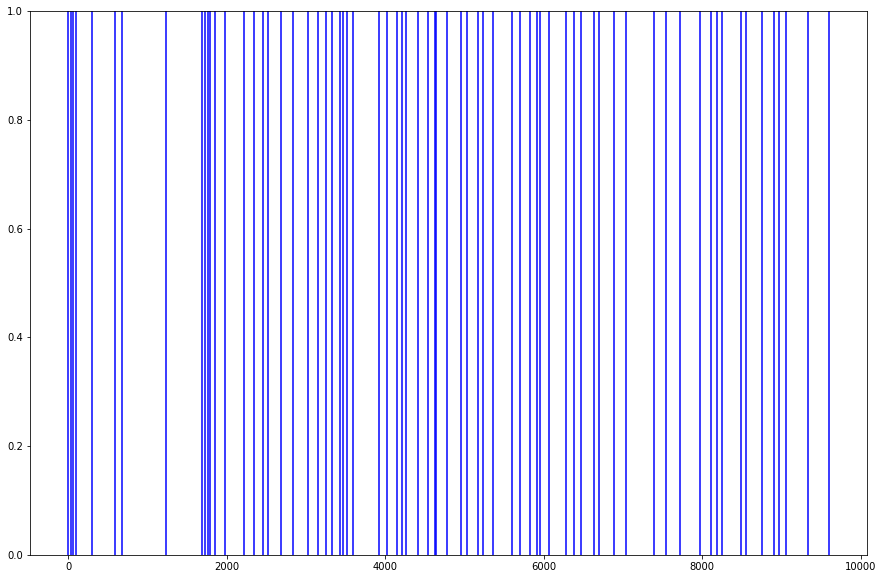

In [ ]:
for i in change_points[0]:
  plt.rcParams["figure.figsize"] = (15,10)
  plt.axvline(x = i[0], color = 'b', label = 'axvline - full height')
plt.show()

In [ ]:
df 
all = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
GT_score = []
stdev_all_GT = []
for i in range(0,352353,60):
  total = 0
  abc = []
  for j in all:
    number = df.iloc[i][j]
    total += number
    abc.append(number)
  stdev_all_GT.append(np.std(abc))
  GT_score.append(total/len(all))